<a href="https://colab.research.google.com/github/amirkasaei/Multi-Class-Weather-Classification/blob/main/Multi_Class_Weather_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

---



In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, add
from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from copy import deepcopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Preprocessing**

---



In [ ]:
path = 'Multi-class Weather Dataset'

In [ ]:
def encode_labels(labels):
  labels = np.where(labels == 'Cloudy', 0, labels)
  labels = np.where(labels == 'Rain', 1, labels)
  labels = np.where(labels == 'Shine', 2, labels)
  labels = np.where(labels == 'Sunrise', 3, labels)
  return labels

def fix_images(images, avgHeight, avgWidth):
  temp = images.copy()
  for i in range(len(temp)):
    temp[i] = cv.resize(temp[i], (int(avgWidth), int(avgHeight)))
  return temp

def convertTo4Class(arr):
  tmp = np.zeros((arr.shape[0], 4))
  tmp[np.where(arr=='0')[0], :] = [1, 0, 0, 0]
  tmp[np.where(arr=='1')[0], :] = [0, 1, 0, 0]
  tmp[np.where(arr=='2')[0], :] = [0, 0, 1, 0]
  tmp[np.where(arr=='3')[0], :] = [0, 0, 0, 1]
  return tmp

# function for convert probablity to 0s and 1s for multiple classification
def argmaxKeepDimensions(arr):
    tmp = np.zeros_like(arr)
    tmp[np.arange(len(arr)), arr.argmax(1)] = 1
    return tmp


In [ ]:
images, labels = [], []
avgHeight, avgWidth = 0, 0
for filename in os.listdir(path):
  for filename1 in os.listdir(path+'/'+filename):
      img = cv.imread(path+'/'+filename+'/'+filename1)
      if img is not None:
          images.append(img)
          #print(img.shape)
          labels.append(filename)

In [ ]:
image_width = 100
image_height = 75

# ------------------------------------- fix input images -------------------------------------
fixed_images = fix_images(images, image_height, image_width)
fixed_images, labels = np.array(fixed_images), np.array(labels)
fixed_images = fixed_images / 255

# ------------------------------------- fix output labels -------------------------------------
fixed_labels = labels.reshape(labels.shape[0], 1)
fixed_labels = encode_labels(fixed_labels)
fixed_labels = convertTo4Class(fixed_labels)
print(fixed_images.shape)
print(fixed_labels.shape)

(1123, 75, 100, 3)
(1123, 4)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fixed_images, fixed_labels, test_size=0.2, random_state=20)

In [ ]:
batch_size = X_train.shape[0]//2

In [ ]:
# horizontal flip
horizontal_flip = ImageDataGenerator(horizontal_flip=True, rescale=1./255)

# 40 degrees rotations
rotation = ImageDataGenerator(rotation_range=40, rescale=1./255)

In [ ]:
x, y = next(horizontal_flip.flow_from_directory(path, target_size=(75, 100), batch_size=600))
X_train = np.concatenate((X_train, x), axis=0)
y_train = np.concatenate((y_train, y), axis=0)

Found 1125 images belonging to 4 classes.


In [ ]:
x, y = next(rotation.flow_from_directory(path, target_size=(75, 100), batch_size=400))
X_train = np.concatenate((X_train, x), axis=0)
y_train = np.concatenate((y_train, y), axis=0)

Found 1125 images belonging to 4 classes.


In [ ]:
print("X_train.shape = ", X_train.shape)
print("y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (898, 75, 100, 3)
y_train.shape =  (898, 4)
X_test.shape =  (225, 75, 100, 3)
y_test.shape =  (225, 4)


# **Implementation**

---



## **Neural Network**

In [ ]:
class NN:

  def train(self, X_train, y_train, validation_data, optimizer, epoch):
    self.X_train = X_train
    self.y_train = y_train

    self.model.compile(loss=CategoricalCrossentropy(),
                        optimizer=optimizer, metrics=['accuracy'])

    # best model based on validation accuracy will save in this path
    filepath = 'my_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                                  monitor='val_accuracy',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='max')

    self.history = self.model.fit(X_train, y_train, validation_data=validation_data,
                                  batch_size=32, epochs=epoch, verbose=2, callbacks=[checkpoint]).history

    # best model assign to final model
    self.model = load_model(filepath)

  def evaluate(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
    self.test_result = self.model.evaluate(X_test, y_test, verbose=0)

  def outputResult(self):
    # print("result in training set:", "\ntrain acc= ",
    #       self.history['accuracy'], "\ntrain loss= ", self.history['loss'])
    # print("\nresult in test set:", "\ntest acc= ",
    #       self.history['val_accuracy'], "\ntest loss= ", self.history['val_loss'], '\n')

    # best models based on acc or loss in tarin set or test set
    trainHistory = list(
        map(lambda x, y: [x, y], self.history['accuracy'], self.history['loss']))
    testHistory = list(
        map(lambda x, y: [x, y], self.history['val_accuracy'], self.history['val_loss']))
    print(
        f"\nbest model based on min training set loss:  acc= {min(trainHistory, key = lambda k: k[1])[0]}  loss= {min(trainHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on min test set loss:  acc= {min(testHistory, key = lambda k: k[1])[0]}  loss= {min(testHistory, key = lambda k: k[1])[1]}")
    print(
        f"best model based on max training set accuracy:  acc= {max(trainHistory, key = lambda k: k[0])[0]}  loss= {max(trainHistory, key = lambda k: k[0])[1]}")
    print(
        f"best model based on max test set accuracy:  acc= {max(testHistory, key = lambda k: k[0])[0]}  loss= {max(testHistory, key = lambda k: k[0])[1]}")

    print("\nevaluate dataset with best model based on maximum test set accuracy")
    print("evaluate train set= ", self.model.evaluate(
        self.X_train, self.y_train, verbose=0))
    print("evaluate test set= ", self.test_result)

    y_train_pred = self.model.predict(self.X_train)
    # convert probablities to 0s and 1s
    y_train_pred = argmaxKeepDimensions(y_train_pred)

    y_test_pred = self.model.predict(self.X_test)
    # convert probablities to 0s and 1s
    y_test_pred = argmaxKeepDimensions(y_test_pred)

    # confusion matrix and precision, recall and f1 report
    print('\n', '-'*30, 'metrics for traning set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(
        np.argmax(self.y_train, axis=1), np.argmax(y_train_pred, axis=1)))
    print(metrics.classification_report(self.y_train,
          y_train_pred, digits=3, target_names=['Cloudy', 'Rain', 'Shine', 'Sunrise']))

    # confusion matrix and precision, recall and f1 report
    print('-'*30, 'metrics for test set', '-'*30)
    print("confusion matrix: \n", metrics.confusion_matrix(
        np.argmax(self.y_test, axis=1), np.argmax(y_test_pred, axis=1)))
    print(metrics.classification_report(self.y_test,
          y_test_pred, digits=3, target_names=['Cloudy', 'Rain', 'Shine', 'Sunrise']))

    # self.model.summary()


  def showPlots(self):
    plt.plot(self.history['accuracy'],
              label='training accuracy', marker='.', color='green')
    plt.plot(self.history['val_accuracy'],
              label='test accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(self.history['loss'],
              label='training loss', marker='.', color='green')
    plt.plot(self.history['val_loss'],
              label='test loss', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## **Dense Neural Network**

In [ ]:
class DNN(NN):

  def __init__(self, activiation, layer, dropout=False, batch_norm=False):
    self.model = Sequential()

    # Input layer
    self.model.add(Input(shape=(image_height, image_width, 3)))
    self.model.add(Flatten())
    if dropout:
        self.model.add(Dropout(0.2))
    elif batch_norm:
        self.model.add(BatchNormalization())

    # Hidden layers
    for i in range(layer-1):
        self.model.add(
            Dense(2**(layer-i+2), activation=activiation))
        if dropout:
            self.model.add(Dropout(0.2))
        elif batch_norm:
            self.model.add(BatchNormalization())

    # Output layer
    self.model.add(Dense(4, activation='softmax'))

## **Convolutional Neural Network**

In [ ]:
class CNN(NN):

  def __init__(self, activation, model_number=1):
    self.model = Sequential()

    # --------- Input layer ---------
    self.model.add(Input(shape=(image_height, image_width, 3)))

    # --------- Models ---------
    if model_number == 1:
      self.model1(activation)
    elif model_number == 2:
      self.model2(activation)
    elif model_number == 3:
      self.model3(activation)
    elif model_number == 4:
      self.dropout_model1(activation)
    elif model_number == 5:
      self.dropout_model2(activation)
    elif model_number == 6:
      self.dropout_model3(activation)
    elif model_number == 7:
      self.pooling_model1(activation)
    elif model_number == 8:
      self.pooling_model2(activation)
    elif model_number == 9:
      self.pooling_model3(activation)
    elif model_number == 10:
      self.pooling_model4(activation)
    elif model_number == 11:
      self.pooling_model5(activation)
    elif model_number == 12:
      self.pooling_model6(activation)


    # --------- Output layer ---------
    self.model.add(Dense(4, activation='softmax'))

  def model1(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(16, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(32, 4, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(64, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(64, activation=activation))
    self.model.add(BatchNormalization())
    self.model.add(Dense(32, activation=activation))
    self.model.add(BatchNormalization())
    self.model.add(Dense(16, activation=activation))
    self.model.add(BatchNormalization())

  def model2(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(16, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(BatchNormalization())

    # self.model.add(Conv2D(64, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    # self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    # self.model.add(Dense(64, activation=activation))
    # self.model.add(BatchNormalization())
    self.model.add(Dense(32, activation=activation))
    self.model.add(BatchNormalization())

  def model3(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(128, activation=activation))
    self.model.add(BatchNormalization())

  def dropout_model1(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(64, 3, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 5, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(Dropout(0.2))


    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(128, activation=activation))
    self.model.add(Dropout(0.3))
    self.model.add(Dense(16, activation=activation))
    self.model.add(Dropout(0.2))

  def dropout_model2(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(16, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dropout(0.2))
    self.model.add(Dense(32, activation=activation))
    self.model.add(Dropout(0.2))

  def dropout_model3(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dropout(0.2))
    self.model.add(Dense(128, activation=activation))
    self.model.add(Dropout(0.2))

  def pooling_model1(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(16, 3, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=2, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(32, 3, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=2, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(64, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(64, activation=activation))
    self.model.add(BatchNormalization())
    self.model.add(Dense(32, activation=activation))
    self.model.add(BatchNormalization())

  def pooling_model2(self, activation):
    # Convolutional Layers
    self.model.add(Conv2D(16, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=2, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(32, activation=activation))
    self.model.add(BatchNormalization())


  def pooling_model3(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(128, activation=activation))
    self.model.add(BatchNormalization())

  def pooling_model4(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(32, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(64, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=2, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(128, activation=activation))
    self.model.add(BatchNormalization())
    # self.model.add(Dense(32, activation=activation))
    # self.model.add(BatchNormalization())


  def pooling_model5(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(64, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=2, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(256, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dense(256, activation=activation))
    self.model.add(BatchNormalization())
    # self.model.add(Dense(64, activation=activation))
    # self.model.add(BatchNormalization())

  def pooling_model6(self, activation):

    # Convolutional Layers
    self.model.add(Conv2D(64, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(128, 4, 1, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(MaxPooling2D((2,2), strides=2, padding="valid"))
    self.model.add(BatchNormalization())

    self.model.add(Conv2D(256, 2, 2, padding="valid", dilation_rate=1, activation=activation))
    self.model.add(AveragePooling2D((2,2), strides=1, padding="valid"))
    self.model.add(BatchNormalization())

    # Dense Layers
    self.model.add(Flatten())
    self.model.add(Dropout(0.2))
    self.model.add(Dense(256, activation=activation))
    self.model.add(Dropout(0.2))



## **Inception Network**



In [ ]:
class InceptionNet(NN):

  def __init__(self, activation, model_number=1):
    # Input layer
    input = Input(shape=(image_height, image_width, 3))

    # --------- Models ---------
    if model_number == 1:
      x = self.model1(input, activation)
    elif model_number == 2:
      x = self.model2(input, activation)
    elif model_number == 3:
      x = self.model3(input, activation)
    elif model_number == 4:
      x = self.model4(input, activation)

    # Output layer
    output = Dense(4, activation='softmax')(x)

    self.model = Model(input, output, name='Inception_v3')


  # function for creating a projected inception module
  def inception_module(self, layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    # x = self.inception_module(input, 8, 16, 32, 4, 8, 8)

    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # conv1 = BatchNormalization()(conv1)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # conv3 = BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # conv5 = BatchNormalization()(conv5)

    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

  def naive_inception_module(self, layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out


  def model1(self, input, activation):
    # add inception block 1
    # x = self.inception_module(input, 64, 96, 128, 16, 32, 32)
    x = self.inception_module(input, 8, 16, 32, 4, 8, 8)
    x = BatchNormalization()(x)

    # add inception block 2
    x = self.inception_module(x, 32, 32, 64, 8, 16, 8)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(64, activation=activation)(x)

    return x

  def model2(self, input, activation):
    # add inception block 1
    # x = self.inception_module(input, 64, 96, 128, 16, 32, 32)
    x = self.inception_module(input, 8, 16, 32, 4, 8, 8)
    x = BatchNormalization()(x)

    # add inception block 2
    x = self.inception_module(x, 8, 16, 32, 4, 8, 8)
    x = BatchNormalization()(x)

    # add inception block 3
    x = self.inception_module(x, 32, 32, 64, 8, 16, 8)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(64, activation=activation)(x)

    return x

  def model3(self, input, activation):
    # add inception block 1
    x = self.inception_module(input, 4, 8, 12, 8, 12, 4)
    x = BatchNormalization()(x)

    # add inception block 2
    x = self.inception_module(x, 8, 16, 24, 16, 24, 8)
    x = BatchNormalization()(x)

    # add inception block 3
    x = self.inception_module(x, 4, 8, 12, 8, 12, 4)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)

    return x

  def model4(self, input, activation):
    # add inception block 1
    x = self.inception_module(input, 4, 8, 12, 8, 12, 4)
    x = BatchNormalization()(x)

    x = self.inception_module(x, 4, 8, 12, 8, 12, 4)
    x = BatchNormalization()(x)

    # add inception block 2
    x = self.inception_module(x, 8, 16, 24, 16, 24, 8)
    x = BatchNormalization()(x)

    # add inception block 3
    x = self.inception_module(x, 4, 8, 12, 8, 12, 4)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(128, activation=activation)(x)

    return x


## **Residual Network**

In [ ]:
from keras.layers.convolutional import Conv
class ResNet(NN):

  def __init__(self, activation, model_number=1):
    # Input layer
    input = Input(shape=(image_height, image_width, 3))

    # --------- Models ---------
    if model_number == 1:
      x = self.model1(input, activation)
    elif model_number == 2:
      x = self.model2(input, activation)
    elif model_number == 3:
      x = self.model3(input, activation)
    elif model_number == 4:
      x = self.model4(input, activation)

    # Output layer
    output = Dense(4, activation='softmax')(x)

    self.model = Model(input, output, name='Inception_v3')

  # function for creating an identity or projection residual module
  def residual_module(self, input, n_filters):
    merge_input = input
    # check if the number of filters needs to be increase, assumes channels last format
    if input.shape[-1] != n_filters:
      merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(input)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(input)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

  def model1(self, input, activation):
    x = Conv2D(64, 3, 1, padding="valid", dilation_rate=2)(input)
    x = MaxPooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 128)
    x = BatchNormalization()(x)

    x = Conv2D(128, 5, 2, padding="valid", dilation_rate=1)(x)
    x = MaxPooling2D(pool_size=5, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 64)
    x = BatchNormalization()(x)

    x = Conv2D(256, 3, 1, padding="valid", dilation_rate=1)(x)
    x = AveragePooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)

    return x

  def model2(self, input, activation):
    x = Conv2D(64, 3, 1, padding="valid", dilation_rate=2)(input)
    x = MaxPooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 128)
    x = BatchNormalization()(x)

    x = Conv2D(128, 5, 2, padding="valid", dilation_rate=1)(x)
    x = MaxPooling2D(pool_size=5, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 64)
    x = BatchNormalization()(x)

    x = Conv2D(32, 3, 1, padding="valid", dilation_rate=2)(x)
    x = AveragePooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(128, activation=activation)(x)
    x = Dense(32, activation=activation)(x)

    return x

  def model3(self, input, activation):
    x = Conv2D(64, 3, 1, padding="valid", dilation_rate=2)(input)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 64)
    x = BatchNormalization()(x)

    x = Conv2D(128, 3, 2, padding="valid", dilation_rate=1)(x)
    x = AveragePooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = self.residual_module(x, 64)
    x = BatchNormalization()(x)

    x = Conv2D(64, 3, 1, padding="valid", dilation_rate=1)(x)
    x = AveragePooling2D(pool_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(64, activation=activation)(x)
    x = Dense(32, activation=activation)(x)

    return x

# **DNN models**

## **Model 1**

Epoch 1/100
29/29 - 7s - loss: 0.8954 - accuracy: 0.6812 - val_loss: 2.0129 - val_accuracy: 0.2969 - 7s/epoch - 257ms/step
Epoch 2/100
29/29 - 1s - loss: 0.5445 - accuracy: 0.8046 - val_loss: 1.3855 - val_accuracy: 0.4847 - 1s/epoch - 47ms/step
Epoch 3/100
29/29 - 1s - loss: 0.4080 - accuracy: 0.8657 - val_loss: 0.7918 - val_accuracy: 0.6987 - 1s/epoch - 49ms/step
Epoch 4/100
29/29 - 1s - loss: 0.3905 - accuracy: 0.8581 - val_loss: 0.7347 - val_accuracy: 0.7336 - 1s/epoch - 48ms/step
Epoch 5/100
29/29 - 1s - loss: 0.3736 - accuracy: 0.8821 - val_loss: 0.5612 - val_accuracy: 0.8079 - 1s/epoch - 48ms/step
Epoch 6/100
29/29 - 1s - loss: 0.3063 - accuracy: 0.8985 - val_loss: 0.5326 - val_accuracy: 0.7817 - 924ms/epoch - 32ms/step
Epoch 7/100
29/29 - 1s - loss: 0.2993 - accuracy: 0.8985 - val_loss: 0.4412 - val_accuracy: 0.8166 - 1s/epoch - 48ms/step
Epoch 8/100
29/29 - 1s - loss: 0.2310 - accuracy: 0.9258 - val_loss: 0.4503 - val_accuracy: 0.8253 - 1s/epoch - 48ms/step
Epoch 9/100
29/29 - 

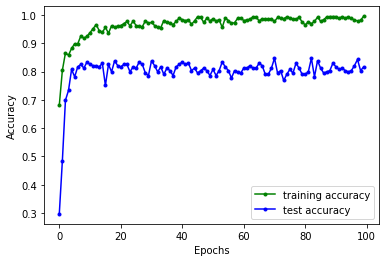

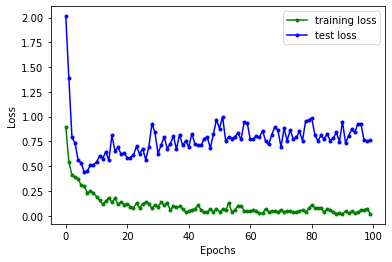

In [ ]:
with tf.device('/GPU:0'):
  model1 = DNN('relu', layer=7, batch_norm=True)
  model1.train(X_train, y_train, (X_test, y_test), Nadam(0.001), 100)
  model1.evaluate(X_test, y_test)
  model1.outputResult()
  model1.showPlots()

Epoch 1/100
60/60 - 5s - loss: 0.9735 - accuracy: 0.6238 - val_loss: 1.3199 - val_accuracy: 0.4044 - 5s/epoch - 82ms/step
Epoch 2/100
60/60 - 1s - loss: 0.6623 - accuracy: 0.7529 - val_loss: 0.8587 - val_accuracy: 0.6667 - 1s/epoch - 24ms/step
Epoch 3/100
60/60 - 1s - loss: 0.5588 - accuracy: 0.7940 - val_loss: 0.6937 - val_accuracy: 0.7067 - 1s/epoch - 25ms/step
Epoch 4/100
60/60 - 1s - loss: 0.4776 - accuracy: 0.8256 - val_loss: 0.6407 - val_accuracy: 0.7689 - 1s/epoch - 24ms/step
Epoch 5/100
60/60 - 1s - loss: 0.4347 - accuracy: 0.8388 - val_loss: 0.5490 - val_accuracy: 0.7956 - 1s/epoch - 25ms/step
Epoch 6/100
60/60 - 1s - loss: 0.3754 - accuracy: 0.8693 - val_loss: 0.5189 - val_accuracy: 0.7867 - 1s/epoch - 18ms/step
Epoch 7/100
60/60 - 1s - loss: 0.3546 - accuracy: 0.8757 - val_loss: 0.5710 - val_accuracy: 0.7778 - 1s/epoch - 18ms/step
Epoch 8/100
60/60 - 1s - loss: 0.3291 - accuracy: 0.8809 - val_loss: 0.4768 - val_accuracy: 0.8222 - 1s/epoch - 24ms/step
Epoch 9/100
60/60 - 1s -

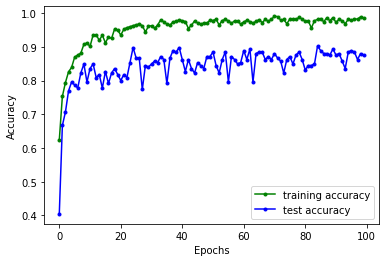

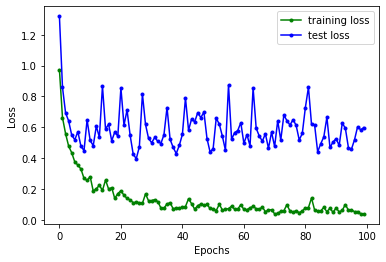

In [ ]:
with tf.device('/GPU:0'):
  model1a = DNN('relu', layer=7, batch_norm=True)
  model1a.train(X_train, y_train, (X_test, y_test), Nadam(0.001), 100)
  model1a.evaluate(X_test, y_test)
  model1a.outputResult()
  model1a.showPlots()

## **Model 2**

Epoch 1/100
29/29 - 4s - loss: 0.9586 - accuracy: 0.6179 - val_loss: 1.4223 - val_accuracy: 0.2838 - 4s/epoch - 142ms/step
Epoch 2/100
29/29 - 1s - loss: 0.6225 - accuracy: 0.7893 - val_loss: 1.2192 - val_accuracy: 0.4279 - 984ms/epoch - 34ms/step
Epoch 3/100
29/29 - 1s - loss: 0.5197 - accuracy: 0.8362 - val_loss: 1.0251 - val_accuracy: 0.5852 - 1s/epoch - 35ms/step
Epoch 4/100
29/29 - 1s - loss: 0.4793 - accuracy: 0.8373 - val_loss: 0.8917 - val_accuracy: 0.6900 - 992ms/epoch - 34ms/step
Epoch 5/100
29/29 - 1s - loss: 0.4071 - accuracy: 0.8777 - val_loss: 0.7578 - val_accuracy: 0.7249 - 1s/epoch - 35ms/step
Epoch 6/100
29/29 - 1s - loss: 0.3495 - accuracy: 0.9017 - val_loss: 0.7264 - val_accuracy: 0.7424 - 982ms/epoch - 34ms/step
Epoch 7/100
29/29 - 1s - loss: 0.3306 - accuracy: 0.8974 - val_loss: 0.6480 - val_accuracy: 0.7948 - 989ms/epoch - 34ms/step
Epoch 8/100
29/29 - 1s - loss: 0.2866 - accuracy: 0.9116 - val_loss: 0.6043 - val_accuracy: 0.7860 - 567ms/epoch - 20ms/step
Epoch 9/

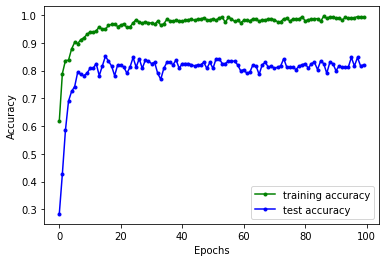

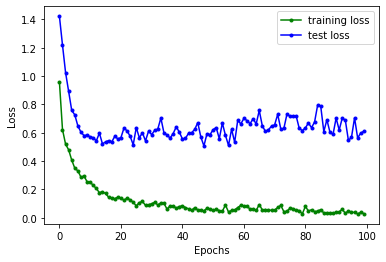

In [ ]:
with tf.device('/GPU:0'):
  model2 = DNN('relu', layer=7, batch_norm=True)
  model2.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model2.evaluate(X_test, y_test)
  model2.outputResult()
  model2.showPlots()

Epoch 1/100
60/60 - 3s - loss: 1.1114 - accuracy: 0.5469 - val_loss: 1.2565 - val_accuracy: 0.4533 - 3s/epoch - 46ms/step
Epoch 2/100
60/60 - 1s - loss: 0.7400 - accuracy: 0.7050 - val_loss: 0.9966 - val_accuracy: 0.6844 - 1s/epoch - 17ms/step
Epoch 3/100
60/60 - 1s - loss: 0.6254 - accuracy: 0.7576 - val_loss: 0.7843 - val_accuracy: 0.7289 - 974ms/epoch - 16ms/step
Epoch 4/100
60/60 - 1s - loss: 0.5445 - accuracy: 0.7977 - val_loss: 0.6803 - val_accuracy: 0.7333 - 1s/epoch - 17ms/step
Epoch 5/100
60/60 - 1s - loss: 0.5234 - accuracy: 0.8024 - val_loss: 0.6654 - val_accuracy: 0.7644 - 959ms/epoch - 16ms/step
Epoch 6/100
60/60 - 1s - loss: 0.4739 - accuracy: 0.8325 - val_loss: 0.5554 - val_accuracy: 0.8000 - 970ms/epoch - 16ms/step
Epoch 7/100
60/60 - 1s - loss: 0.4300 - accuracy: 0.8425 - val_loss: 0.5224 - val_accuracy: 0.8267 - 1s/epoch - 17ms/step
Epoch 8/100
60/60 - 1s - loss: 0.4067 - accuracy: 0.8509 - val_loss: 0.4845 - val_accuracy: 0.8444 - 994ms/epoch - 17ms/step
Epoch 9/100


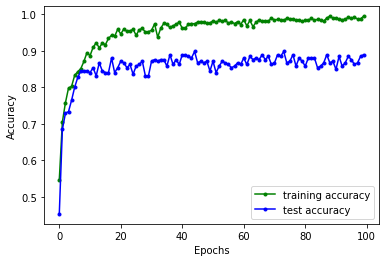

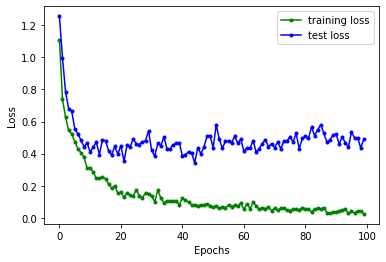

In [ ]:
with tf.device('/GPU:0'):
  model2a = DNN('relu', layer=7, batch_norm=True)
  model2a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model2a.evaluate(X_test, y_test)
  model2a.outputResult()
  model2a.showPlots()

## **Model 3**

Epoch 1/100
29/29 - 4s - loss: 0.8931 - accuracy: 0.6517 - val_loss: 1.3507 - val_accuracy: 0.3668 - 4s/epoch - 124ms/step
Epoch 2/100
29/29 - 1s - loss: 0.6000 - accuracy: 0.7773 - val_loss: 1.1097 - val_accuracy: 0.5197 - 983ms/epoch - 34ms/step
Epoch 3/100
29/29 - 1s - loss: 0.5114 - accuracy: 0.8308 - val_loss: 0.8667 - val_accuracy: 0.6943 - 898ms/epoch - 31ms/step
Epoch 4/100
29/29 - 1s - loss: 0.4109 - accuracy: 0.8592 - val_loss: 0.6801 - val_accuracy: 0.7555 - 998ms/epoch - 34ms/step
Epoch 5/100
29/29 - 1s - loss: 0.3770 - accuracy: 0.8635 - val_loss: 0.6707 - val_accuracy: 0.7380 - 525ms/epoch - 18ms/step
Epoch 6/100
29/29 - 1s - loss: 0.3660 - accuracy: 0.8614 - val_loss: 0.5983 - val_accuracy: 0.7642 - 942ms/epoch - 32ms/step
Epoch 7/100
29/29 - 1s - loss: 0.3578 - accuracy: 0.8624 - val_loss: 0.5698 - val_accuracy: 0.7729 - 946ms/epoch - 33ms/step
Epoch 8/100
29/29 - 1s - loss: 0.2887 - accuracy: 0.9050 - val_loss: 0.4612 - val_accuracy: 0.8253 - 994ms/epoch - 34ms/step
Ep

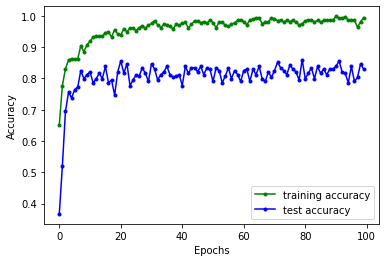

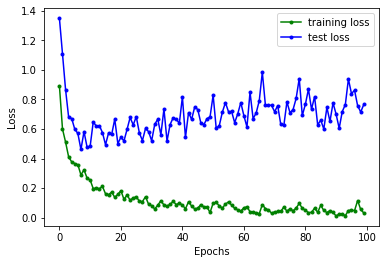

In [ ]:
with tf.device('/GPU:0'):
  model3 = DNN('relu', layer=7, batch_norm=True)
  model3.train(X_train, y_train, (X_test, y_test), Adam(0.001), 100)
  model3.evaluate(X_test, y_test)
  model3.outputResult()
  model3.showPlots()

Epoch 1/100
60/60 - 3s - loss: 1.0438 - accuracy: 0.5969 - val_loss: 1.3185 - val_accuracy: 0.3867 - 3s/epoch - 45ms/step
Epoch 2/100
60/60 - 1s - loss: 0.7147 - accuracy: 0.7187 - val_loss: 0.9071 - val_accuracy: 0.6756 - 949ms/epoch - 16ms/step
Epoch 3/100
60/60 - 1s - loss: 0.6694 - accuracy: 0.7255 - val_loss: 0.8541 - val_accuracy: 0.6667 - 631ms/epoch - 11ms/step
Epoch 4/100
60/60 - 1s - loss: 0.5984 - accuracy: 0.7634 - val_loss: 0.7318 - val_accuracy: 0.7200 - 967ms/epoch - 16ms/step
Epoch 5/100
60/60 - 1s - loss: 0.5045 - accuracy: 0.7993 - val_loss: 0.6078 - val_accuracy: 0.7600 - 1s/epoch - 17ms/step
Epoch 6/100
60/60 - 1s - loss: 0.4720 - accuracy: 0.8188 - val_loss: 0.4989 - val_accuracy: 0.8089 - 963ms/epoch - 16ms/step
Epoch 7/100
60/60 - 1s - loss: 0.4099 - accuracy: 0.8419 - val_loss: 0.4504 - val_accuracy: 0.8356 - 928ms/epoch - 15ms/step
Epoch 8/100
60/60 - 1s - loss: 0.3712 - accuracy: 0.8546 - val_loss: 0.4308 - val_accuracy: 0.7956 - 609ms/epoch - 10ms/step
Epoch 

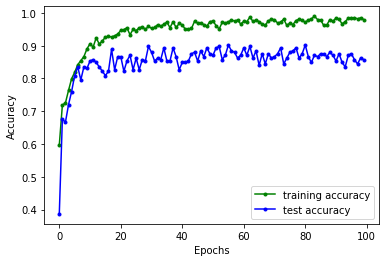

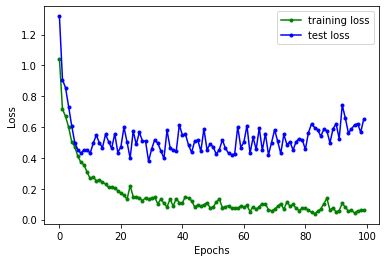

In [ ]:
with tf.device('/GPU:0'):
  model3a = DNN('relu', layer=7, batch_norm=True)
  model3a.train(X_train, y_train, (X_test, y_test), Adam(0.001), 100)
  model3a.evaluate(X_test, y_test)
  model3a.outputResult()
  model3a.showPlots()

# **CNN models**

## **Simple Models**

### **Model 1**

Epoch 1/100
29/29 - 2s - loss: 0.6887 - accuracy: 0.7528 - val_loss: 1.3123 - val_accuracy: 0.3200 - 2s/epoch - 84ms/step
Epoch 2/100
29/29 - 0s - loss: 0.3643 - accuracy: 0.8898 - val_loss: 1.3675 - val_accuracy: 0.3200 - 332ms/epoch - 11ms/step
Epoch 3/100
29/29 - 0s - loss: 0.2974 - accuracy: 0.9109 - val_loss: 1.3816 - val_accuracy: 0.3200 - 332ms/epoch - 11ms/step
Epoch 4/100
29/29 - 0s - loss: 0.2228 - accuracy: 0.9499 - val_loss: 1.4393 - val_accuracy: 0.3511 - 435ms/epoch - 15ms/step
Epoch 5/100
29/29 - 0s - loss: 0.1700 - accuracy: 0.9655 - val_loss: 1.4509 - val_accuracy: 0.3689 - 471ms/epoch - 16ms/step
Epoch 6/100
29/29 - 0s - loss: 0.1500 - accuracy: 0.9788 - val_loss: 1.4359 - val_accuracy: 0.4444 - 429ms/epoch - 15ms/step
Epoch 7/100
29/29 - 0s - loss: 0.1447 - accuracy: 0.9744 - val_loss: 1.2230 - val_accuracy: 0.4933 - 491ms/epoch - 17ms/step
Epoch 8/100
29/29 - 0s - loss: 0.1167 - accuracy: 0.9866 - val_loss: 1.2585 - val_accuracy: 0.4489 - 352ms/epoch - 12ms/step
Epo

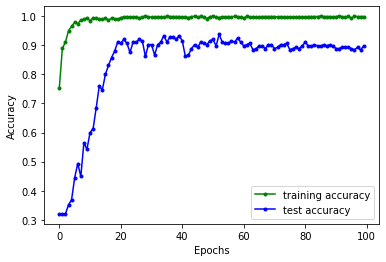

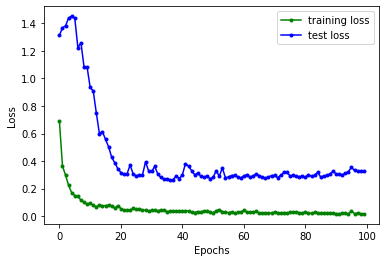

In [ ]:
with tf.device('/GPU:0'):
  model4 = CNN('relu', model_number=1)
  model4.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model4.evaluate(X_test, y_test)
  model4.outputResult()
  model4.showPlots()

Epoch 1/100
60/60 - 3s - loss: 0.7316 - accuracy: 0.7187 - val_loss: 1.5111 - val_accuracy: 0.3378 - 3s/epoch - 46ms/step
Epoch 2/100
60/60 - 1s - loss: 0.3806 - accuracy: 0.8825 - val_loss: 1.7161 - val_accuracy: 0.3733 - 709ms/epoch - 12ms/step
Epoch 3/100
60/60 - 1s - loss: 0.2482 - accuracy: 0.9347 - val_loss: 1.8090 - val_accuracy: 0.3511 - 579ms/epoch - 10ms/step
Epoch 4/100
60/60 - 1s - loss: 0.1952 - accuracy: 0.9557 - val_loss: 1.5588 - val_accuracy: 0.4222 - 723ms/epoch - 12ms/step
Epoch 5/100
60/60 - 1s - loss: 0.1394 - accuracy: 0.9789 - val_loss: 1.4523 - val_accuracy: 0.4178 - 582ms/epoch - 10ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1112 - accuracy: 0.9805 - val_loss: 1.0642 - val_accuracy: 0.6267 - 725ms/epoch - 12ms/step
Epoch 7/100
60/60 - 1s - loss: 0.0792 - accuracy: 0.9926 - val_loss: 0.8195 - val_accuracy: 0.7156 - 696ms/epoch - 12ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0810 - accuracy: 0.9858 - val_loss: 0.5851 - val_accuracy: 0.8133 - 731ms/epoch - 12ms/step
Epo

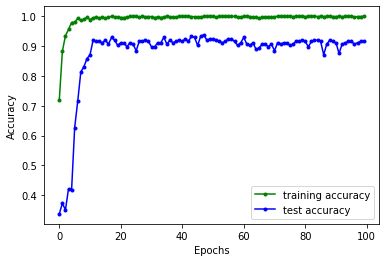

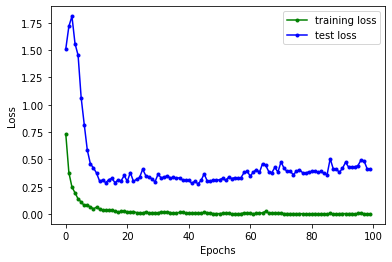

In [ ]:
with tf.device('/GPU:0'):
  model4a = CNN('relu', model_number=1)
  model4a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model4a.evaluate(X_test, y_test)
  model4a.outputResult()
  model4a.showPlots()

### **Model 2**

Epoch 1/100
29/29 - 3s - loss: 0.5782 - accuracy: 0.7937 - val_loss: 0.9951 - val_accuracy: 0.5546 - 3s/epoch - 102ms/step
Epoch 2/100
29/29 - 1s - loss: 0.3566 - accuracy: 0.8843 - val_loss: 0.9288 - val_accuracy: 0.6725 - 1s/epoch - 48ms/step
Epoch 3/100
29/29 - 1s - loss: 0.2865 - accuracy: 0.9148 - val_loss: 0.9475 - val_accuracy: 0.6245 - 1s/epoch - 38ms/step
Epoch 4/100
29/29 - 1s - loss: 0.2306 - accuracy: 0.9301 - val_loss: 0.9085 - val_accuracy: 0.6114 - 1s/epoch - 39ms/step
Epoch 5/100
29/29 - 1s - loss: 0.1888 - accuracy: 0.9421 - val_loss: 0.8909 - val_accuracy: 0.6725 - 1s/epoch - 38ms/step
Epoch 6/100
29/29 - 1s - loss: 0.1601 - accuracy: 0.9574 - val_loss: 0.9130 - val_accuracy: 0.6332 - 1s/epoch - 40ms/step
Epoch 7/100
29/29 - 1s - loss: 0.1134 - accuracy: 0.9771 - val_loss: 0.8757 - val_accuracy: 0.6943 - 1s/epoch - 46ms/step
Epoch 8/100
29/29 - 1s - loss: 0.0984 - accuracy: 0.9782 - val_loss: 0.8194 - val_accuracy: 0.6288 - 1s/epoch - 38ms/step
Epoch 9/100
29/29 - 1s 

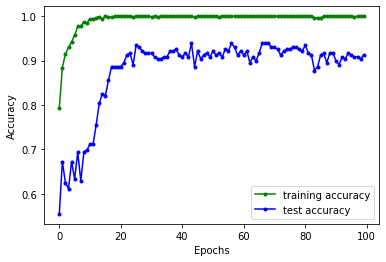

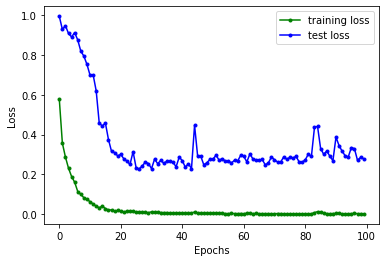

In [ ]:
with tf.device('/GPU:0'):
  model5 = CNN('relu', model_number=2)
  model5.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model5.evaluate(X_test, y_test)
  model5.outputResult()
  model5.showPlots()

Epoch 1/100
60/60 - 4s - loss: 0.8941 - accuracy: 0.6697 - val_loss: 1.5855 - val_accuracy: 0.2933 - 4s/epoch - 66ms/step
Epoch 2/100
60/60 - 1s - loss: 0.5044 - accuracy: 0.8130 - val_loss: 1.8589 - val_accuracy: 0.3778 - 1s/epoch - 20ms/step
Epoch 3/100
60/60 - 1s - loss: 0.3642 - accuracy: 0.8804 - val_loss: 1.8612 - val_accuracy: 0.3956 - 1s/epoch - 20ms/step
Epoch 4/100
60/60 - 1s - loss: 0.2468 - accuracy: 0.9283 - val_loss: 1.9110 - val_accuracy: 0.3644 - 982ms/epoch - 16ms/step
Epoch 5/100
60/60 - 1s - loss: 0.1825 - accuracy: 0.9547 - val_loss: 1.5181 - val_accuracy: 0.4356 - 1s/epoch - 20ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1341 - accuracy: 0.9679 - val_loss: 1.5501 - val_accuracy: 0.3600 - 994ms/epoch - 17ms/step
Epoch 7/100
60/60 - 1s - loss: 0.0958 - accuracy: 0.9842 - val_loss: 1.1002 - val_accuracy: 0.5689 - 1s/epoch - 20ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0725 - accuracy: 0.9879 - val_loss: 0.7628 - val_accuracy: 0.6889 - 1s/epoch - 22ms/step
Epoch 9/100
60/60 

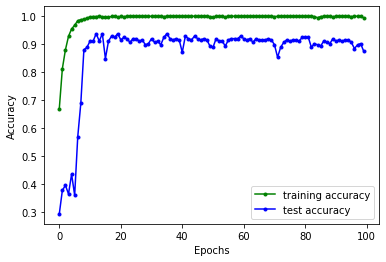

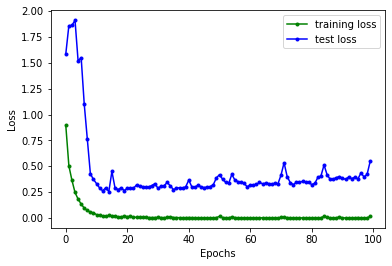

In [ ]:
with tf.device('/GPU:0'):
  model5a = CNN('relu', model_number=2)
  model5a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model5a.evaluate(X_test, y_test)
  model5a.outputResult()
  model5a.showPlots()

### **Model 3**

Epoch 1/100
29/29 - 4s - loss: 0.6365 - accuracy: 0.7980 - val_loss: 1.1529 - val_accuracy: 0.4105 - 4s/epoch - 128ms/step
Epoch 2/100
29/29 - 1s - loss: 0.3647 - accuracy: 0.8712 - val_loss: 1.4064 - val_accuracy: 0.2140 - 1s/epoch - 41ms/step
Epoch 3/100
29/29 - 1s - loss: 0.2926 - accuracy: 0.9072 - val_loss: 1.6357 - val_accuracy: 0.2009 - 1s/epoch - 41ms/step
Epoch 4/100
29/29 - 1s - loss: 0.2509 - accuracy: 0.9225 - val_loss: 1.8568 - val_accuracy: 0.2009 - 1s/epoch - 40ms/step
Epoch 5/100
29/29 - 1s - loss: 0.1695 - accuracy: 0.9531 - val_loss: 2.1235 - val_accuracy: 0.2009 - 1s/epoch - 38ms/step
Epoch 6/100
29/29 - 1s - loss: 0.1430 - accuracy: 0.9552 - val_loss: 2.4167 - val_accuracy: 0.2009 - 1s/epoch - 38ms/step
Epoch 7/100
29/29 - 1s - loss: 0.1013 - accuracy: 0.9782 - val_loss: 2.5321 - val_accuracy: 0.2009 - 1s/epoch - 41ms/step
Epoch 8/100
29/29 - 1s - loss: 0.0704 - accuracy: 0.9836 - val_loss: 2.7533 - val_accuracy: 0.2052 - 1s/epoch - 45ms/step
Epoch 9/100
29/29 - 1s 

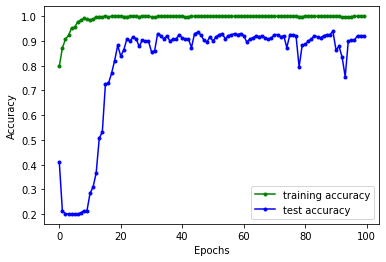

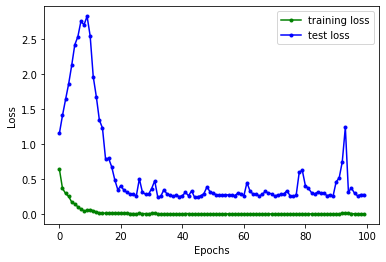

In [ ]:
with tf.device('/GPU:0'):
  model6 = CNN('relu', model_number=3)
  model6.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model6.evaluate(X_test, y_test)
  model6.outputResult()
  model6.showPlots()

Epoch 1/100
60/60 - 3s - loss: 0.6838 - accuracy: 0.7692 - val_loss: 1.6774 - val_accuracy: 0.3244 - 3s/epoch - 58ms/step
Epoch 2/100
60/60 - 2s - loss: 0.3851 - accuracy: 0.8609 - val_loss: 2.1968 - val_accuracy: 0.3911 - 2s/epoch - 33ms/step
Epoch 3/100
60/60 - 2s - loss: 0.2613 - accuracy: 0.9136 - val_loss: 2.5044 - val_accuracy: 0.4000 - 2s/epoch - 35ms/step
Epoch 4/100
60/60 - 1s - loss: 0.1951 - accuracy: 0.9394 - val_loss: 2.6049 - val_accuracy: 0.2889 - 1s/epoch - 19ms/step
Epoch 5/100
60/60 - 1s - loss: 0.1473 - accuracy: 0.9515 - val_loss: 2.3174 - val_accuracy: 0.3022 - 1s/epoch - 19ms/step
Epoch 6/100
60/60 - 2s - loss: 0.1209 - accuracy: 0.9621 - val_loss: 1.8103 - val_accuracy: 0.4400 - 2s/epoch - 35ms/step
Epoch 7/100
60/60 - 2s - loss: 0.0914 - accuracy: 0.9758 - val_loss: 1.0584 - val_accuracy: 0.6533 - 2s/epoch - 35ms/step
Epoch 8/100
60/60 - 2s - loss: 0.0683 - accuracy: 0.9826 - val_loss: 0.7716 - val_accuracy: 0.6933 - 2s/epoch - 38ms/step
Epoch 9/100
60/60 - 2s -

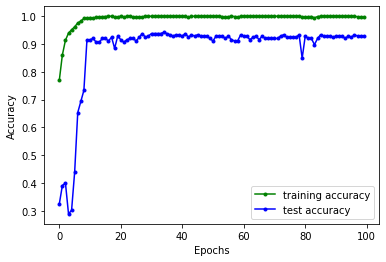

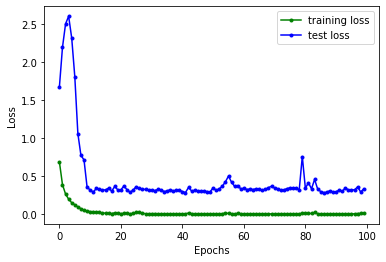

In [ ]:
with tf.device('/GPU:0'):
  model6a = CNN('relu', model_number=3)
  model6a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model6a.evaluate(X_test, y_test)
  model6a.outputResult()
  model6a.showPlots()

## **Dropout Models**

### **Model 4**


Epoch 1/100
60/60 - 5s - loss: 2.0596 - accuracy: 0.4055 - val_loss: 1.3583 - val_accuracy: 0.2271 - 5s/epoch - 76ms/step
Epoch 2/100
60/60 - 3s - loss: 0.9660 - accuracy: 0.5835 - val_loss: 1.2790 - val_accuracy: 0.3319 - 3s/epoch - 50ms/step
Epoch 3/100
60/60 - 3s - loss: 0.6894 - accuracy: 0.7422 - val_loss: 1.2756 - val_accuracy: 0.4541 - 3s/epoch - 51ms/step
Epoch 4/100
60/60 - 3s - loss: 0.6112 - accuracy: 0.7792 - val_loss: 1.3040 - val_accuracy: 0.4629 - 3s/epoch - 49ms/step
Epoch 5/100
60/60 - 3s - loss: 0.4752 - accuracy: 0.8225 - val_loss: 1.1832 - val_accuracy: 0.5895 - 3s/epoch - 48ms/step
Epoch 6/100
60/60 - 3s - loss: 0.4535 - accuracy: 0.8340 - val_loss: 0.8422 - val_accuracy: 0.7031 - 3s/epoch - 48ms/step
Epoch 7/100
60/60 - 3s - loss: 0.3747 - accuracy: 0.8617 - val_loss: 0.5998 - val_accuracy: 0.8166 - 3s/epoch - 50ms/step
Epoch 8/100
60/60 - 3s - loss: 0.2893 - accuracy: 0.8977 - val_loss: 0.4150 - val_accuracy: 0.8821 - 3s/epoch - 52ms/step
Epoch 9/100
60/60 - 3s -

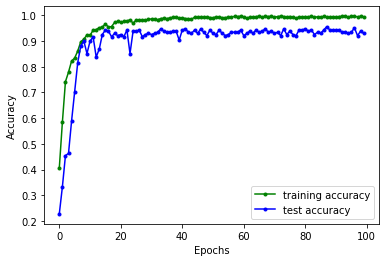

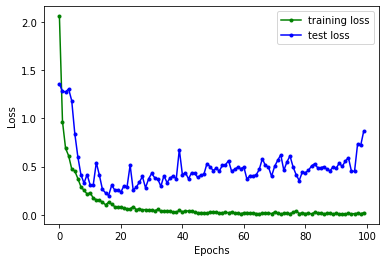

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 73, 98, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 73, 98, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_37 (Conv2D)          (None, 35, 47, 128)       204928    
                                                                 
 dropout (Dropout)           (None, 35, 47, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 210560)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               26951808  
                                                        

In [ ]:
with tf.device('/GPU:0'):
  model7 = CNN('relu', model_number=4)
  model7.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model7.evaluate(X_test, y_test)
  model7.outputResult()
  model7.showPlots()
  model7.model.summary()

### **Model 5**

Epoch 1/100
60/60 - 2s - loss: 6.0859 - accuracy: 0.6628 - val_loss: 1.2134 - val_accuracy: 0.4978 - 2s/epoch - 38ms/step
Epoch 2/100
60/60 - 1s - loss: 1.2591 - accuracy: 0.7667 - val_loss: 1.3149 - val_accuracy: 0.2227 - 1s/epoch - 18ms/step
Epoch 3/100
60/60 - 1s - loss: 0.6875 - accuracy: 0.8283 - val_loss: 1.4153 - val_accuracy: 0.3930 - 1s/epoch - 18ms/step
Epoch 4/100
60/60 - 1s - loss: 0.4475 - accuracy: 0.8695 - val_loss: 1.5833 - val_accuracy: 0.4629 - 1s/epoch - 18ms/step
Epoch 5/100
60/60 - 1s - loss: 0.3063 - accuracy: 0.8826 - val_loss: 1.4418 - val_accuracy: 0.4847 - 1s/epoch - 18ms/step
Epoch 6/100
60/60 - 1s - loss: 0.2384 - accuracy: 0.9050 - val_loss: 1.1477 - val_accuracy: 0.6157 - 1s/epoch - 21ms/step
Epoch 7/100
60/60 - 1s - loss: 0.2309 - accuracy: 0.9201 - val_loss: 0.9817 - val_accuracy: 0.6638 - 1s/epoch - 20ms/step
Epoch 8/100
60/60 - 1s - loss: 0.1639 - accuracy: 0.9415 - val_loss: 0.6778 - val_accuracy: 0.7817 - 1s/epoch - 21ms/step
Epoch 9/100
60/60 - 1s -

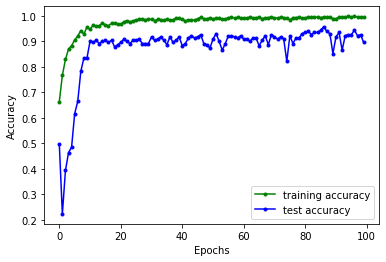

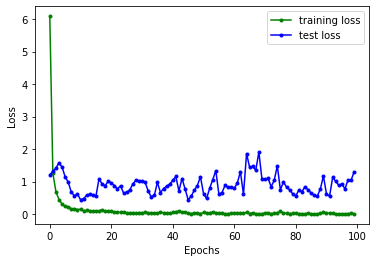

In [ ]:
with tf.device('/GPU:0'):
  model8 = CNN('relu', model_number=5)
  model8.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model8.evaluate(X_test, y_test)
  model8.outputResult()
  model8.showPlots()

### **Model 6**

Epoch 1/100
60/60 - 3s - loss: 11.6946 - accuracy: 0.7578 - val_loss: 1.3904 - val_accuracy: 0.4498 - 3s/epoch - 52ms/step
Epoch 2/100
60/60 - 1s - loss: 1.6491 - accuracy: 0.8899 - val_loss: 1.3401 - val_accuracy: 0.3275 - 1s/epoch - 20ms/step
Epoch 3/100
60/60 - 2s - loss: 0.8017 - accuracy: 0.9389 - val_loss: 1.6916 - val_accuracy: 0.4891 - 2s/epoch - 36ms/step
Epoch 4/100
60/60 - 1s - loss: 0.3143 - accuracy: 0.9676 - val_loss: 1.9671 - val_accuracy: 0.4541 - 1s/epoch - 20ms/step
Epoch 5/100
60/60 - 2s - loss: 0.1597 - accuracy: 0.9755 - val_loss: 0.8645 - val_accuracy: 0.6943 - 2s/epoch - 34ms/step
Epoch 6/100
60/60 - 2s - loss: 0.0494 - accuracy: 0.9859 - val_loss: 1.0812 - val_accuracy: 0.7118 - 2s/epoch - 37ms/step
Epoch 7/100
60/60 - 2s - loss: 0.0677 - accuracy: 0.9833 - val_loss: 0.6966 - val_accuracy: 0.8297 - 2s/epoch - 35ms/step
Epoch 8/100
60/60 - 1s - loss: 0.1356 - accuracy: 0.9833 - val_loss: 1.1262 - val_accuracy: 0.8122 - 1s/epoch - 20ms/step
Epoch 9/100
60/60 - 2s 

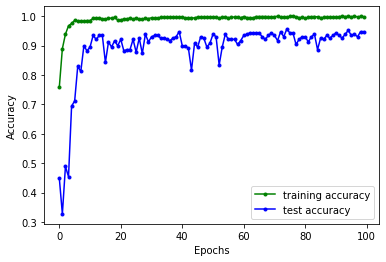

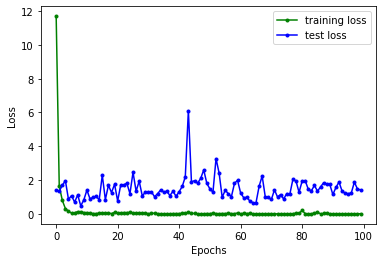

In [ ]:
with tf.device('/GPU:0'):
  model9 = CNN('relu', model_number=6)
  model9.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model9.evaluate(X_test, y_test)
  model9.outputResult()
  model9.showPlots()

## **Pooling Models**

### **Model 7**


Epoch 1/100
29/29 - 1s - loss: 0.6251 - accuracy: 0.7661 - val_loss: 1.3103 - val_accuracy: 0.4400 - 1s/epoch - 51ms/step
Epoch 2/100
29/29 - 0s - loss: 0.3313 - accuracy: 0.8909 - val_loss: 1.4298 - val_accuracy: 0.1778 - 298ms/epoch - 10ms/step
Epoch 3/100
29/29 - 0s - loss: 0.2625 - accuracy: 0.9198 - val_loss: 1.5927 - val_accuracy: 0.1644 - 261ms/epoch - 9ms/step
Epoch 4/100
29/29 - 0s - loss: 0.2274 - accuracy: 0.9365 - val_loss: 1.7940 - val_accuracy: 0.1644 - 253ms/epoch - 9ms/step
Epoch 5/100
29/29 - 0s - loss: 0.1823 - accuracy: 0.9454 - val_loss: 1.8797 - val_accuracy: 0.1644 - 247ms/epoch - 9ms/step
Epoch 6/100
29/29 - 0s - loss: 0.1465 - accuracy: 0.9688 - val_loss: 2.1605 - val_accuracy: 0.1644 - 254ms/epoch - 9ms/step
Epoch 7/100
29/29 - 0s - loss: 0.1430 - accuracy: 0.9666 - val_loss: 2.2620 - val_accuracy: 0.1778 - 285ms/epoch - 10ms/step
Epoch 8/100
29/29 - 0s - loss: 0.1392 - accuracy: 0.9655 - val_loss: 2.4114 - val_accuracy: 0.2044 - 283ms/epoch - 10ms/step
Epoch 9

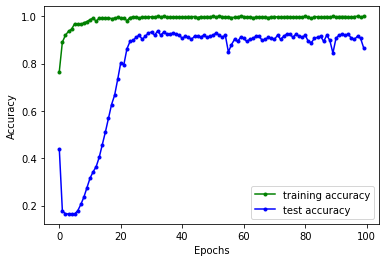

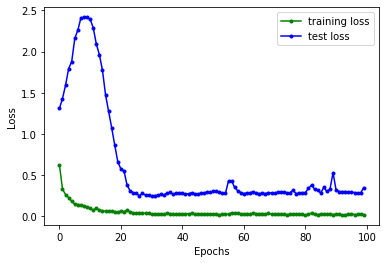

In [ ]:
with tf.device('/GPU:0'):
  model10 = CNN('relu', model_number=7)
  model10.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model10.evaluate(X_test, y_test)
  model10.outputResult()
  model10.showPlots()

Epoch 1/100
60/60 - 2s - loss: 0.6851 - accuracy: 0.7376 - val_loss: 1.3461 - val_accuracy: 0.3644 - 2s/epoch - 34ms/step
Epoch 2/100
60/60 - 0s - loss: 0.3630 - accuracy: 0.8767 - val_loss: 1.5519 - val_accuracy: 0.1822 - 434ms/epoch - 7ms/step
Epoch 3/100
60/60 - 0s - loss: 0.2543 - accuracy: 0.9183 - val_loss: 1.8321 - val_accuracy: 0.1689 - 476ms/epoch - 8ms/step
Epoch 4/100
60/60 - 0s - loss: 0.1998 - accuracy: 0.9399 - val_loss: 2.0492 - val_accuracy: 0.2489 - 482ms/epoch - 8ms/step
Epoch 5/100
60/60 - 0s - loss: 0.1639 - accuracy: 0.9552 - val_loss: 2.1664 - val_accuracy: 0.3467 - 429ms/epoch - 7ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1293 - accuracy: 0.9689 - val_loss: 1.5711 - val_accuracy: 0.4756 - 500ms/epoch - 8ms/step
Epoch 7/100
60/60 - 1s - loss: 0.0970 - accuracy: 0.9816 - val_loss: 1.3931 - val_accuracy: 0.5422 - 529ms/epoch - 9ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0984 - accuracy: 0.9747 - val_loss: 0.8394 - val_accuracy: 0.6889 - 522ms/epoch - 9ms/step
Epoch 9/10

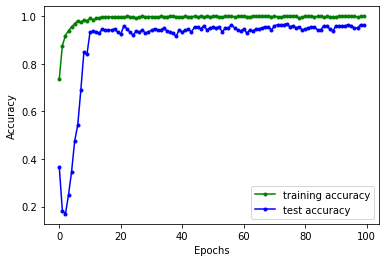

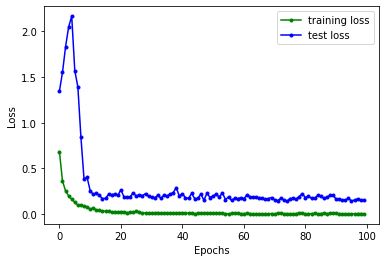

In [ ]:
with tf.device('/GPU:0'):
  model10a = CNN('relu', model_number=7)
  model10a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model10a.evaluate(X_test, y_test)
  model10a.outputResult()
  model10a.showPlots()

### **Model 8**


Epoch 1/100
29/29 - 2s - loss: 0.7210 - accuracy: 0.7294 - val_loss: 1.1695 - val_accuracy: 0.4444 - 2s/epoch - 56ms/step
Epoch 2/100
29/29 - 1s - loss: 0.4111 - accuracy: 0.8641 - val_loss: 1.2122 - val_accuracy: 0.3733 - 532ms/epoch - 18ms/step
Epoch 3/100
29/29 - 1s - loss: 0.3049 - accuracy: 0.9020 - val_loss: 1.3831 - val_accuracy: 0.2889 - 544ms/epoch - 19ms/step
Epoch 4/100
29/29 - 1s - loss: 0.2218 - accuracy: 0.9321 - val_loss: 1.6487 - val_accuracy: 0.2933 - 538ms/epoch - 19ms/step
Epoch 5/100
29/29 - 1s - loss: 0.1812 - accuracy: 0.9499 - val_loss: 1.7843 - val_accuracy: 0.3156 - 540ms/epoch - 19ms/step
Epoch 6/100
29/29 - 1s - loss: 0.1447 - accuracy: 0.9644 - val_loss: 2.0151 - val_accuracy: 0.3422 - 546ms/epoch - 19ms/step
Epoch 7/100
29/29 - 1s - loss: 0.1123 - accuracy: 0.9777 - val_loss: 2.0974 - val_accuracy: 0.3733 - 551ms/epoch - 19ms/step
Epoch 8/100
29/29 - 1s - loss: 0.1000 - accuracy: 0.9777 - val_loss: 2.0976 - val_accuracy: 0.3867 - 539ms/epoch - 19ms/step
Epo

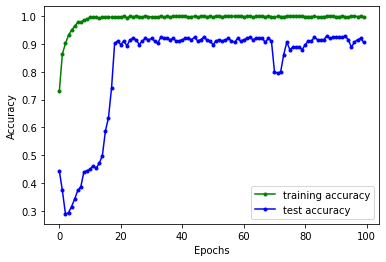

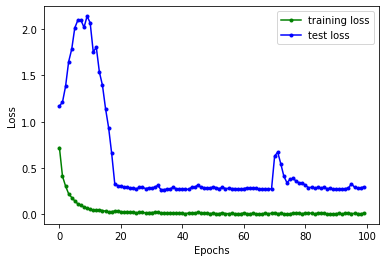

In [ ]:
with tf.device('/GPU:0'):
  model11 = CNN('relu', model_number=8)
  model11.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model11.evaluate(X_test, y_test)
  model11.outputResult()
  model11.showPlots()

Epoch 1/100
60/60 - 2s - loss: 0.8221 - accuracy: 0.6897 - val_loss: 1.3186 - val_accuracy: 0.2178 - 2s/epoch - 38ms/step
Epoch 2/100
60/60 - 1s - loss: 0.4948 - accuracy: 0.8272 - val_loss: 1.5336 - val_accuracy: 0.2400 - 1s/epoch - 20ms/step
Epoch 3/100
60/60 - 1s - loss: 0.3924 - accuracy: 0.8541 - val_loss: 1.6966 - val_accuracy: 0.2133 - 1s/epoch - 18ms/step
Epoch 4/100
60/60 - 1s - loss: 0.2702 - accuracy: 0.9178 - val_loss: 1.7984 - val_accuracy: 0.2267 - 1s/epoch - 18ms/step
Epoch 5/100
60/60 - 1s - loss: 0.2151 - accuracy: 0.9431 - val_loss: 1.9719 - val_accuracy: 0.2444 - 1s/epoch - 20ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1774 - accuracy: 0.9499 - val_loss: 1.3699 - val_accuracy: 0.4000 - 1s/epoch - 20ms/step
Epoch 7/100
60/60 - 1s - loss: 0.1347 - accuracy: 0.9705 - val_loss: 1.3260 - val_accuracy: 0.4444 - 1s/epoch - 21ms/step
Epoch 8/100
60/60 - 1s - loss: 0.1000 - accuracy: 0.9831 - val_loss: 1.0883 - val_accuracy: 0.5378 - 1s/epoch - 20ms/step
Epoch 9/100
60/60 - 1s -

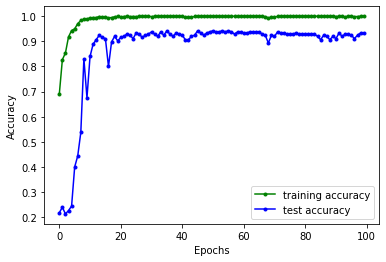

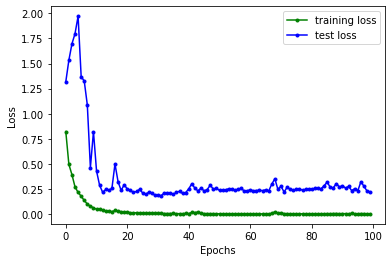

In [ ]:
with tf.device('/GPU:0'):
  model11a = CNN('relu', model_number=8)
  model11a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model11a.evaluate(X_test, y_test)
  model11a.outputResult()
  model11a.showPlots()

### **Model 9**


Epoch 1/100
29/29 - 2s - loss: 0.8103 - accuracy: 0.7494 - val_loss: 1.0552 - val_accuracy: 0.5511 - 2s/epoch - 84ms/step
Epoch 2/100
29/29 - 1s - loss: 0.4262 - accuracy: 0.8474 - val_loss: 1.1195 - val_accuracy: 0.3556 - 632ms/epoch - 22ms/step
Epoch 3/100
29/29 - 1s - loss: 0.3612 - accuracy: 0.8708 - val_loss: 1.1745 - val_accuracy: 0.3467 - 619ms/epoch - 21ms/step
Epoch 4/100
29/29 - 1s - loss: 0.3077 - accuracy: 0.8909 - val_loss: 1.1956 - val_accuracy: 0.3556 - 616ms/epoch - 21ms/step
Epoch 5/100
29/29 - 1s - loss: 0.2836 - accuracy: 0.8931 - val_loss: 1.3452 - val_accuracy: 0.3022 - 627ms/epoch - 22ms/step
Epoch 6/100
29/29 - 1s - loss: 0.2460 - accuracy: 0.9154 - val_loss: 1.3750 - val_accuracy: 0.3333 - 619ms/epoch - 21ms/step
Epoch 7/100
29/29 - 1s - loss: 0.1951 - accuracy: 0.9376 - val_loss: 1.4523 - val_accuracy: 0.3156 - 633ms/epoch - 22ms/step
Epoch 8/100
29/29 - 1s - loss: 0.1524 - accuracy: 0.9477 - val_loss: 1.5655 - val_accuracy: 0.2933 - 618ms/epoch - 21ms/step
Epo

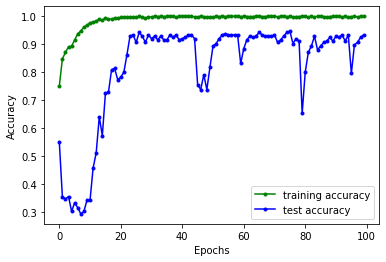

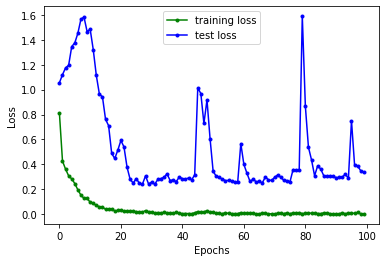

In [ ]:
with tf.device('/GPU:0'):
  model12 = CNN('relu', model_number=9)
  model12.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model12.evaluate(X_test, y_test)
  model12.outputResult()
  model12.showPlots()

Epoch 1/100
60/60 - 3s - loss: 0.6696 - accuracy: 0.7729 - val_loss: 1.3384 - val_accuracy: 0.4133 - 3s/epoch - 49ms/step
Epoch 2/100
60/60 - 1s - loss: 0.4080 - accuracy: 0.8446 - val_loss: 1.4311 - val_accuracy: 0.2400 - 1s/epoch - 20ms/step
Epoch 3/100
60/60 - 1s - loss: 0.2977 - accuracy: 0.8946 - val_loss: 1.4678 - val_accuracy: 0.2267 - 1s/epoch - 20ms/step
Epoch 4/100
60/60 - 1s - loss: 0.2318 - accuracy: 0.9141 - val_loss: 1.5628 - val_accuracy: 0.2444 - 1s/epoch - 20ms/step
Epoch 5/100
60/60 - 1s - loss: 0.1858 - accuracy: 0.9341 - val_loss: 1.6835 - val_accuracy: 0.2978 - 1s/epoch - 20ms/step
Epoch 6/100
60/60 - 1s - loss: 0.1399 - accuracy: 0.9584 - val_loss: 1.8788 - val_accuracy: 0.3244 - 1s/epoch - 20ms/step
Epoch 7/100
60/60 - 2s - loss: 0.1048 - accuracy: 0.9694 - val_loss: 1.7229 - val_accuracy: 0.4178 - 2s/epoch - 34ms/step
Epoch 8/100
60/60 - 2s - loss: 0.0790 - accuracy: 0.9789 - val_loss: 1.6147 - val_accuracy: 0.5156 - 2s/epoch - 35ms/step
Epoch 9/100
60/60 - 2s -

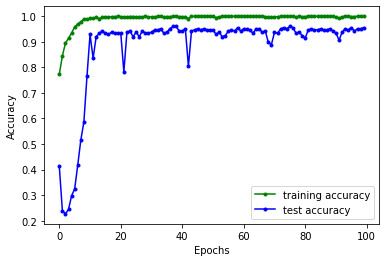

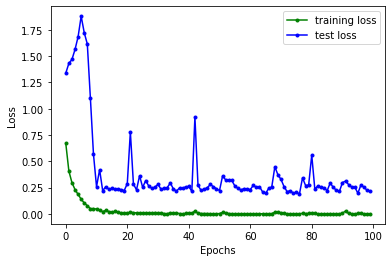

In [ ]:
with tf.device('/GPU:0'):
  model12a = CNN('relu', model_number=9)
  model12a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model12a.evaluate(X_test, y_test)
  model12a.outputResult()
  model12a.showPlots()

### **Model 10**


Epoch 1/100
29/29 - 2s - loss: 0.6434 - accuracy: 0.7895 - val_loss: 1.1908 - val_accuracy: 0.5511 - 2s/epoch - 77ms/step
Epoch 2/100
29/29 - 1s - loss: 0.2985 - accuracy: 0.8964 - val_loss: 1.1827 - val_accuracy: 0.4800 - 757ms/epoch - 26ms/step
Epoch 3/100
29/29 - 1s - loss: 0.2016 - accuracy: 0.9310 - val_loss: 1.4816 - val_accuracy: 0.2356 - 752ms/epoch - 26ms/step
Epoch 4/100
29/29 - 1s - loss: 0.1377 - accuracy: 0.9566 - val_loss: 1.7665 - val_accuracy: 0.1822 - 752ms/epoch - 26ms/step
Epoch 5/100
29/29 - 1s - loss: 0.0939 - accuracy: 0.9710 - val_loss: 1.9647 - val_accuracy: 0.1733 - 749ms/epoch - 26ms/step
Epoch 6/100
29/29 - 1s - loss: 0.0684 - accuracy: 0.9900 - val_loss: 2.2075 - val_accuracy: 0.1733 - 747ms/epoch - 26ms/step
Epoch 7/100
29/29 - 1s - loss: 0.0751 - accuracy: 0.9811 - val_loss: 1.9316 - val_accuracy: 0.2267 - 745ms/epoch - 26ms/step
Epoch 8/100
29/29 - 1s - loss: 0.0557 - accuracy: 0.9866 - val_loss: 1.8613 - val_accuracy: 0.2889 - 757ms/epoch - 26ms/step
Epo

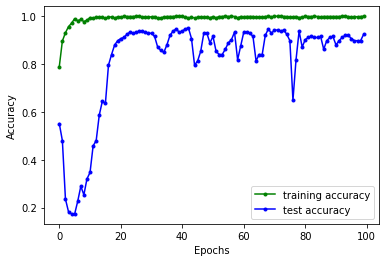

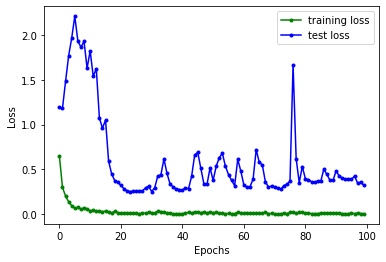

In [ ]:
with tf.device('/GPU:0'):
  model14 = CNN('relu', model_number=10)
  model14.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model14.evaluate(X_test, y_test)
  model14.outputResult()
  model14.showPlots()

Epoch 1/100
60/60 - 3s - loss: 0.6339 - accuracy: 0.8077 - val_loss: 2.1989 - val_accuracy: 0.1778 - 3s/epoch - 54ms/step
Epoch 2/100
60/60 - 1s - loss: 0.2748 - accuracy: 0.8999 - val_loss: 2.2775 - val_accuracy: 0.1644 - 1s/epoch - 24ms/step
Epoch 3/100
60/60 - 1s - loss: 0.1673 - accuracy: 0.9457 - val_loss: 2.3242 - val_accuracy: 0.1778 - 1s/epoch - 24ms/step
Epoch 4/100
60/60 - 2s - loss: 0.1274 - accuracy: 0.9568 - val_loss: 2.3289 - val_accuracy: 0.2178 - 2s/epoch - 28ms/step
Epoch 5/100
60/60 - 2s - loss: 0.1099 - accuracy: 0.9636 - val_loss: 1.9324 - val_accuracy: 0.3200 - 2s/epoch - 27ms/step
Epoch 6/100
60/60 - 2s - loss: 0.0824 - accuracy: 0.9773 - val_loss: 1.8663 - val_accuracy: 0.4533 - 2s/epoch - 27ms/step
Epoch 7/100
60/60 - 2s - loss: 0.0532 - accuracy: 0.9889 - val_loss: 0.5665 - val_accuracy: 0.8133 - 2s/epoch - 27ms/step
Epoch 8/100
60/60 - 2s - loss: 0.0347 - accuracy: 0.9916 - val_loss: 0.4416 - val_accuracy: 0.8533 - 2s/epoch - 31ms/step
Epoch 9/100
60/60 - 2s -

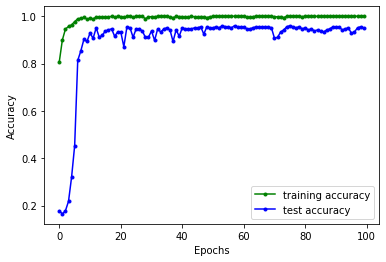

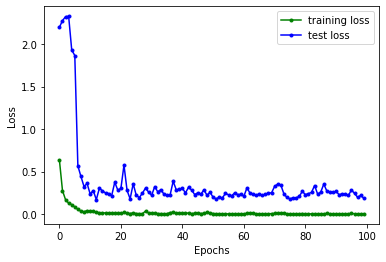

In [ ]:
with tf.device('/GPU:0'):
  model14a = CNN('relu', model_number=10)
  model14a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model14a.evaluate(X_test, y_test)
  model14a.outputResult()
  model14a.showPlots()

### **Model 11**


Epoch 1/100
29/29 - 3s - loss: 0.8215 - accuracy: 0.8107 - val_loss: 1.3374 - val_accuracy: 0.4844 - 3s/epoch - 117ms/step
Epoch 2/100
29/29 - 2s - loss: 0.2788 - accuracy: 0.9065 - val_loss: 2.0300 - val_accuracy: 0.1644 - 2s/epoch - 61ms/step
Epoch 3/100
29/29 - 2s - loss: 0.1836 - accuracy: 0.9454 - val_loss: 2.8910 - val_accuracy: 0.1644 - 2s/epoch - 61ms/step
Epoch 4/100
29/29 - 2s - loss: 0.2105 - accuracy: 0.9265 - val_loss: 3.3070 - val_accuracy: 0.1644 - 2s/epoch - 61ms/step
Epoch 5/100
29/29 - 2s - loss: 0.1531 - accuracy: 0.9510 - val_loss: 3.7939 - val_accuracy: 0.1644 - 2s/epoch - 61ms/step
Epoch 6/100
29/29 - 2s - loss: 0.1578 - accuracy: 0.9521 - val_loss: 3.1985 - val_accuracy: 0.1644 - 2s/epoch - 62ms/step
Epoch 7/100
29/29 - 2s - loss: 0.1010 - accuracy: 0.9621 - val_loss: 3.6992 - val_accuracy: 0.1644 - 2s/epoch - 62ms/step
Epoch 8/100
29/29 - 2s - loss: 0.0640 - accuracy: 0.9788 - val_loss: 3.4956 - val_accuracy: 0.1689 - 2s/epoch - 63ms/step
Epoch 9/100
29/29 - 2s 

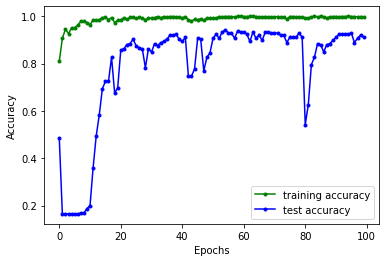

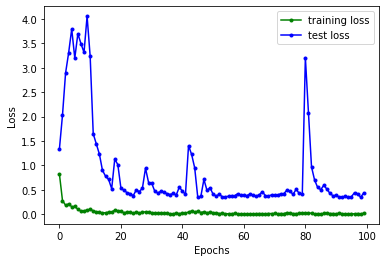

In [ ]:
with tf.device('/GPU:0'):
  model20 = CNN('relu', model_number=11)
  model20.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model20.evaluate(X_test, y_test)
  model20.outputResult()
  model20.showPlots()

Epoch 1/100
60/60 - 7s - loss: 0.7024 - accuracy: 0.8074 - val_loss: 1.8820 - val_accuracy: 0.3537 - 7s/epoch - 120ms/step
Epoch 2/100
60/60 - 4s - loss: 0.3190 - accuracy: 0.8914 - val_loss: 1.3485 - val_accuracy: 0.4148 - 4s/epoch - 67ms/step
Epoch 3/100
60/60 - 4s - loss: 0.1721 - accuracy: 0.9426 - val_loss: 1.3432 - val_accuracy: 0.4585 - 4s/epoch - 68ms/step
Epoch 4/100
60/60 - 4s - loss: 0.1271 - accuracy: 0.9535 - val_loss: 1.1010 - val_accuracy: 0.5109 - 4s/epoch - 66ms/step
Epoch 5/100
60/60 - 3s - loss: 0.1053 - accuracy: 0.9582 - val_loss: 1.6306 - val_accuracy: 0.4279 - 3s/epoch - 54ms/step
Epoch 6/100
60/60 - 4s - loss: 0.1032 - accuracy: 0.9614 - val_loss: 1.3049 - val_accuracy: 0.6070 - 4s/epoch - 69ms/step
Epoch 7/100
60/60 - 4s - loss: 0.0855 - accuracy: 0.9692 - val_loss: 0.5738 - val_accuracy: 0.7860 - 4s/epoch - 69ms/step
Epoch 8/100
60/60 - 3s - loss: 0.0533 - accuracy: 0.9833 - val_loss: 0.9104 - val_accuracy: 0.6900 - 3s/epoch - 55ms/step
Epoch 9/100
60/60 - 4s 

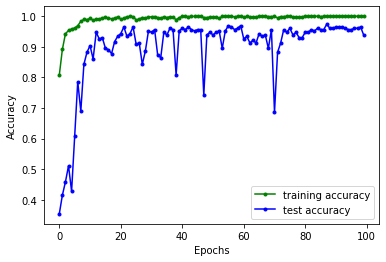

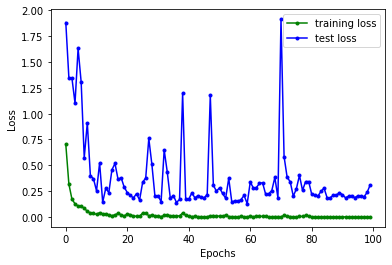

In [ ]:
with tf.device('/GPU:0'):
  model20a = CNN('relu', model_number=11)
  model20a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model20a.evaluate(X_test, y_test)
  model20a.outputResult()
  model20a.showPlots()

### **Model 12**
dropout

Epoch 1/100
60/60 - 5s - loss: 8.0340 - accuracy: 0.7537 - val_loss: 6.3058 - val_accuracy: 0.4585 - 5s/epoch - 82ms/step
Epoch 2/100
60/60 - 3s - loss: 2.9134 - accuracy: 0.8580 - val_loss: 5.8937 - val_accuracy: 0.2271 - 3s/epoch - 55ms/step
Epoch 3/100
60/60 - 3s - loss: 1.3783 - accuracy: 0.9087 - val_loss: 14.0165 - val_accuracy: 0.2009 - 3s/epoch - 55ms/step
Epoch 4/100
60/60 - 3s - loss: 0.5737 - accuracy: 0.9405 - val_loss: 5.5928 - val_accuracy: 0.3581 - 3s/epoch - 56ms/step
Epoch 5/100
60/60 - 3s - loss: 0.3653 - accuracy: 0.9619 - val_loss: 5.5002 - val_accuracy: 0.3974 - 3s/epoch - 56ms/step
Epoch 6/100
60/60 - 3s - loss: 0.4095 - accuracy: 0.9619 - val_loss: 6.9225 - val_accuracy: 0.4148 - 3s/epoch - 55ms/step
Epoch 7/100
60/60 - 4s - loss: 0.1581 - accuracy: 0.9729 - val_loss: 3.6660 - val_accuracy: 0.6201 - 4s/epoch - 66ms/step
Epoch 8/100
60/60 - 3s - loss: 0.2062 - accuracy: 0.9718 - val_loss: 5.1500 - val_accuracy: 0.5328 - 3s/epoch - 55ms/step
Epoch 9/100
60/60 - 4s 

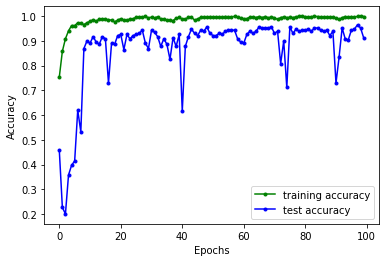

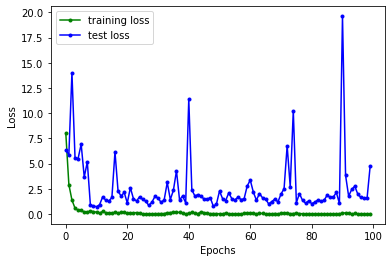

In [ ]:
with tf.device('/GPU:0'):
  model22 = CNN('relu', model_number=12)
  model22.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model22.evaluate(X_test, y_test)
  model22.outputResult()
  model22.showPlots()

# **Inception Net Models**

## **Model1**

Epoch 1/100
29/29 - 8s - loss: 54.4500 - accuracy: 0.7729 - val_loss: 23.1198 - val_accuracy: 0.5022 - 8s/epoch - 289ms/step
Epoch 2/100
29/29 - 2s - loss: 6.1622 - accuracy: 0.9312 - val_loss: 12.3019 - val_accuracy: 0.4585 - 2s/epoch - 76ms/step
Epoch 3/100
29/29 - 2s - loss: 1.5792 - accuracy: 0.9552 - val_loss: 13.2304 - val_accuracy: 0.5022 - 2s/epoch - 75ms/step
Epoch 4/100
29/29 - 2s - loss: 0.7484 - accuracy: 0.9793 - val_loss: 20.1119 - val_accuracy: 0.4454 - 2s/epoch - 75ms/step
Epoch 5/100
29/29 - 2s - loss: 0.6452 - accuracy: 0.9771 - val_loss: 37.5735 - val_accuracy: 0.3057 - 2s/epoch - 75ms/step
Epoch 6/100
29/29 - 2s - loss: 0.3496 - accuracy: 0.9847 - val_loss: 25.0808 - val_accuracy: 0.4760 - 2s/epoch - 75ms/step
Epoch 7/100
29/29 - 5s - loss: 0.1337 - accuracy: 0.9924 - val_loss: 21.2127 - val_accuracy: 0.5633 - 5s/epoch - 160ms/step
Epoch 8/100
29/29 - 5s - loss: 0.1137 - accuracy: 0.9934 - val_loss: 23.9649 - val_accuracy: 0.5677 - 5s/epoch - 158ms/step
Epoch 9/100


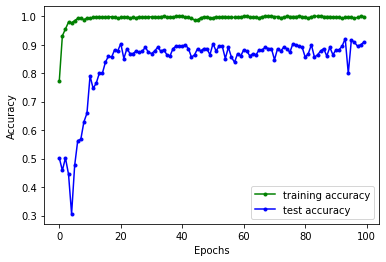

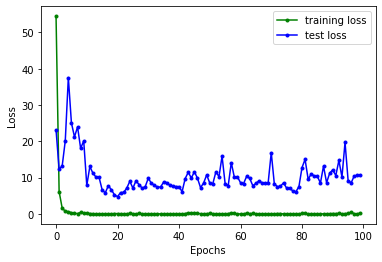

In [ ]:
with tf.device('/GPU:0'):
  model13 = InceptionNet('relu', model_number=1)
  model13.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model13.evaluate(X_test, y_test)
  model13.outputResult()
  model13.showPlots()
  model13.model.summary()
  plot_model(model13.model, show_shapes=True, to_file='inception_net1.png')

Epoch 1/100
60/60 - 8s - loss: 30.1829 - accuracy: 0.7524 - val_loss: 9.1908 - val_accuracy: 0.4533 - 8s/epoch - 137ms/step
Epoch 2/100
60/60 - 4s - loss: 3.3546 - accuracy: 0.8783 - val_loss: 16.3805 - val_accuracy: 0.4400 - 4s/epoch - 71ms/step
Epoch 3/100
60/60 - 4s - loss: 0.9734 - accuracy: 0.9368 - val_loss: 27.0954 - val_accuracy: 0.4489 - 4s/epoch - 72ms/step
Epoch 4/100
60/60 - 7s - loss: 0.4680 - accuracy: 0.9568 - val_loss: 23.8938 - val_accuracy: 0.4978 - 7s/epoch - 123ms/step
Epoch 5/100
60/60 - 7s - loss: 0.3688 - accuracy: 0.9626 - val_loss: 13.3714 - val_accuracy: 0.6000 - 7s/epoch - 116ms/step
Epoch 6/100
60/60 - 7s - loss: 0.0839 - accuracy: 0.9752 - val_loss: 7.4127 - val_accuracy: 0.7244 - 7s/epoch - 114ms/step
Epoch 7/100
60/60 - 7s - loss: 0.1308 - accuracy: 0.9789 - val_loss: 5.6171 - val_accuracy: 0.7689 - 7s/epoch - 116ms/step
Epoch 8/100
60/60 - 7s - loss: 0.0602 - accuracy: 0.9889 - val_loss: 2.9380 - val_accuracy: 0.8844 - 7s/epoch - 115ms/step
Epoch 9/100
6

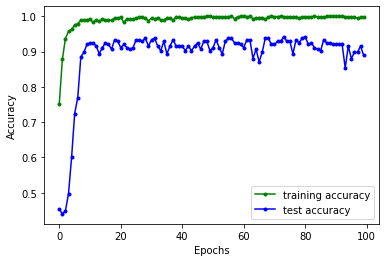

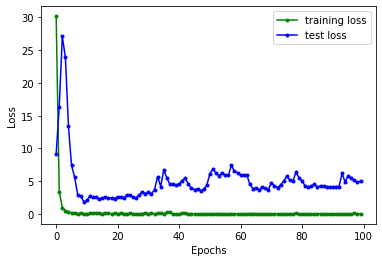

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 75, 100, 16)  64          ['input_25[0][0]']               
                                                                                                  
 conv2d_41 (Conv2D)             (None, 75, 100, 4)   16          ['input_25[0][0]']               
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 75, 100, 3)  0           ['input_25[0][0]']    

In [ ]:
with tf.device('/GPU:0'):
  model13a = InceptionNet('relu', model_number=1)
  model13a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model13a.evaluate(X_test, y_test)
  model13a.outputResult()
  model13a.showPlots()
  model13a.model.summary()
  plot_model(model13a.model, show_shapes=True, to_file='inception_net1.png')

## **Model 2**

Epoch 1/100
29/29 - 19s - loss: 25.7354 - accuracy: 0.7828 - val_loss: 17.1279 - val_accuracy: 0.3231 - 19s/epoch - 639ms/step
Epoch 2/100
29/29 - 3s - loss: 2.1203 - accuracy: 0.9312 - val_loss: 34.3073 - val_accuracy: 0.3231 - 3s/epoch - 95ms/step
Epoch 3/100
29/29 - 3s - loss: 0.9130 - accuracy: 0.9651 - val_loss: 51.3638 - val_accuracy: 0.3231 - 3s/epoch - 93ms/step
Epoch 4/100
29/29 - 3s - loss: 0.4783 - accuracy: 0.9574 - val_loss: 59.0533 - val_accuracy: 0.3231 - 3s/epoch - 93ms/step
Epoch 5/100
29/29 - 3s - loss: 0.0977 - accuracy: 0.9836 - val_loss: 73.2837 - val_accuracy: 0.3231 - 3s/epoch - 93ms/step
Epoch 6/100
29/29 - 3s - loss: 0.0910 - accuracy: 0.9847 - val_loss: 79.3709 - val_accuracy: 0.3231 - 3s/epoch - 94ms/step
Epoch 7/100
29/29 - 3s - loss: 0.1715 - accuracy: 0.9858 - val_loss: 84.1498 - val_accuracy: 0.3231 - 3s/epoch - 93ms/step
Epoch 8/100
29/29 - 3s - loss: 0.2067 - accuracy: 0.9760 - val_loss: 84.9969 - val_accuracy: 0.3231 - 3s/epoch - 95ms/step
Epoch 9/100


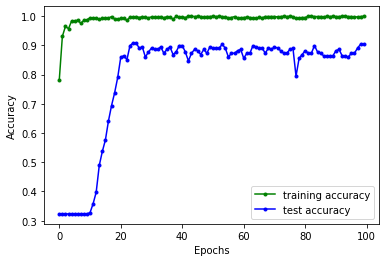

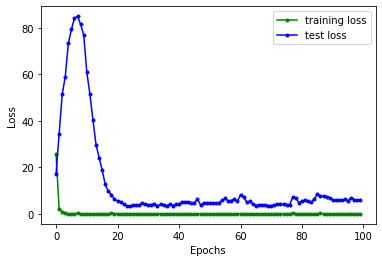

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 75, 100, 16)  64          ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 75, 100, 4)   16          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 75, 100, 3)   0           ['input_1[0][0]']     

In [ ]:
with tf.device('/GPU:0'):
  model14 = InceptionNet('relu', model_number=2)
  model14.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model14.evaluate(X_test, y_test)
  model14.outputResult()
  model14.showPlots()
  model14.model.summary()
  plot_model(model14.model, show_shapes=True, to_file='inception_net2.png')

Epoch 1/100
60/60 - 10s - loss: 13.8788 - accuracy: 0.7881 - val_loss: 16.6751 - val_accuracy: 0.3231 - 10s/epoch - 169ms/step
Epoch 2/100
60/60 - 6s - loss: 0.8702 - accuracy: 0.8711 - val_loss: 21.2774 - val_accuracy: 0.3231 - 6s/epoch - 92ms/step
Epoch 3/100
60/60 - 5s - loss: 0.4263 - accuracy: 0.9055 - val_loss: 25.6656 - val_accuracy: 0.3231 - 5s/epoch - 91ms/step
Epoch 4/100
60/60 - 8s - loss: 0.3121 - accuracy: 0.9311 - val_loss: 23.5957 - val_accuracy: 0.3493 - 8s/epoch - 132ms/step
Epoch 5/100
60/60 - 8s - loss: 0.2214 - accuracy: 0.9509 - val_loss: 12.5172 - val_accuracy: 0.4585 - 8s/epoch - 131ms/step
Epoch 6/100
60/60 - 8s - loss: 0.1896 - accuracy: 0.9541 - val_loss: 10.5780 - val_accuracy: 0.4978 - 8s/epoch - 133ms/step
Epoch 7/100
60/60 - 8s - loss: 0.0789 - accuracy: 0.9723 - val_loss: 6.0643 - val_accuracy: 0.6419 - 8s/epoch - 132ms/step
Epoch 8/100
60/60 - 8s - loss: 0.1033 - accuracy: 0.9739 - val_loss: 3.4232 - val_accuracy: 0.7904 - 8s/epoch - 132ms/step
Epoch 9/1

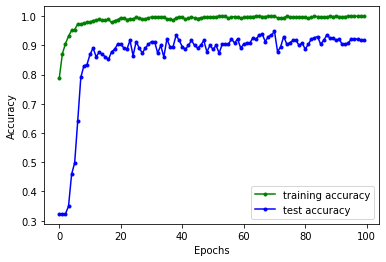

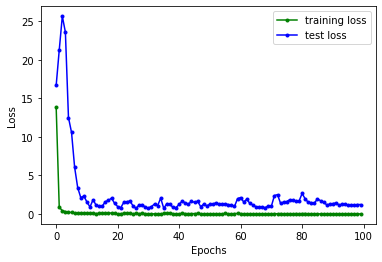

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 75, 100, 16)  64          ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 75, 100, 4)   16          ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 75, 100, 3)  0           ['input_2[0][0]']     

In [ ]:
with tf.device('/GPU:0'):
  model14a = InceptionNet('relu', model_number=2)
  model14a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model14a.evaluate(X_test, y_test)
  model14a.outputResult()
  model14a.showPlots()
  model14a.model.summary()
  plot_model(model14a.model, show_shapes=True, to_file='inception_net2.png')

## **Model 3**

Epoch 1/100
29/29 - 11s - loss: 18.4818 - accuracy: 0.7707 - val_loss: 15.3385 - val_accuracy: 0.3450 - 11s/epoch - 395ms/step
Epoch 2/100
29/29 - 6s - loss: 1.5785 - accuracy: 0.9389 - val_loss: 26.3352 - val_accuracy: 0.3231 - 6s/epoch - 196ms/step
Epoch 3/100
29/29 - 6s - loss: 0.7324 - accuracy: 0.9552 - val_loss: 41.2722 - val_accuracy: 0.3231 - 6s/epoch - 195ms/step
Epoch 4/100
29/29 - 6s - loss: 0.2188 - accuracy: 0.9847 - val_loss: 31.6338 - val_accuracy: 0.3275 - 6s/epoch - 192ms/step
Epoch 5/100
29/29 - 6s - loss: 0.1798 - accuracy: 0.9891 - val_loss: 37.6080 - val_accuracy: 0.3275 - 6s/epoch - 195ms/step
Epoch 6/100
29/29 - 5s - loss: 0.0201 - accuracy: 0.9978 - val_loss: 43.4038 - val_accuracy: 0.3362 - 5s/epoch - 186ms/step
Epoch 7/100
29/29 - 8s - loss: 0.0460 - accuracy: 0.9934 - val_loss: 41.8970 - val_accuracy: 0.3581 - 8s/epoch - 286ms/step
Epoch 8/100
29/29 - 5s - loss: 0.1406 - accuracy: 0.9956 - val_loss: 43.8588 - val_accuracy: 0.3581 - 5s/epoch - 186ms/step
Epoch

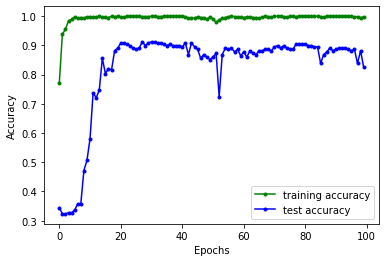

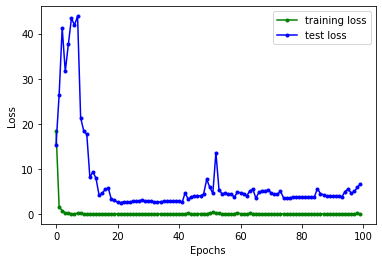

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_91 (Conv2D)             (None, 75, 100, 8)   32          ['input_6[0][0]']                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 75, 100, 8)   32          ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 75, 100, 3)  0           ['input_6[0][0]']     

In [ ]:
with tf.device('/GPU:0'):
  model15 = InceptionNet('relu', model_number=3)
  model15.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model15.evaluate(X_test, y_test)
  model15.outputResult()
  model15.showPlots()
  model15.model.summary()
  plot_model(model15.model, show_shapes=True, to_file='inception_net3.png')

Epoch 1/100
60/60 - 10s - loss: 10.4094 - accuracy: 0.7682 - val_loss: 6.3427 - val_accuracy: 0.3333 - 10s/epoch - 166ms/step
Epoch 2/100
60/60 - 7s - loss: 0.4621 - accuracy: 0.9320 - val_loss: 8.2351 - val_accuracy: 0.3511 - 7s/epoch - 119ms/step
Epoch 3/100
60/60 - 7s - loss: 0.1347 - accuracy: 0.9742 - val_loss: 7.4178 - val_accuracy: 0.3778 - 7s/epoch - 120ms/step
Epoch 4/100
60/60 - 7s - loss: 0.0616 - accuracy: 0.9837 - val_loss: 6.4903 - val_accuracy: 0.4267 - 7s/epoch - 119ms/step
Epoch 5/100
60/60 - 7s - loss: 0.0650 - accuracy: 0.9884 - val_loss: 3.1230 - val_accuracy: 0.5867 - 7s/epoch - 120ms/step
Epoch 6/100
60/60 - 7s - loss: 0.0127 - accuracy: 0.9974 - val_loss: 2.7376 - val_accuracy: 0.6489 - 7s/epoch - 118ms/step
Epoch 7/100
60/60 - 7s - loss: 0.0162 - accuracy: 0.9963 - val_loss: 2.0837 - val_accuracy: 0.7467 - 7s/epoch - 119ms/step
Epoch 8/100
60/60 - 7s - loss: 0.0201 - accuracy: 0.9958 - val_loss: 1.5794 - val_accuracy: 0.8089 - 7s/epoch - 119ms/step
Epoch 9/100
6

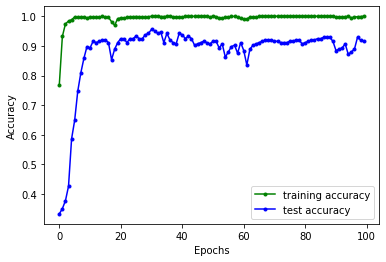

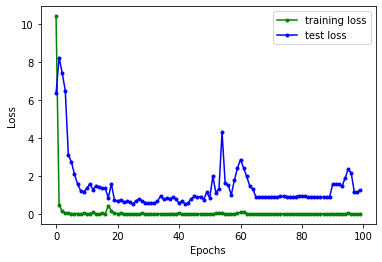

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 75, 100, 8)   32          ['input_3[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 75, 100, 8)   32          ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 75, 100, 3)  0           ['input_3[0][0]']     

In [ ]:
with tf.device('/GPU:0'):
  model15a = InceptionNet('relu', model_number=3)
  model15a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model15a.evaluate(X_test, y_test)
  model15a.outputResult()
  model15a.showPlots()
  model15a.model.summary()
  plot_model(model15a.model, show_shapes=True, to_file='inception_net3.png')

# **ResNet Models**

## **Model 1**

Epoch 1/100
29/29 - 14s - loss: 21.8262 - accuracy: 0.7631 - val_loss: 55.3912 - val_accuracy: 0.6026 - 14s/epoch - 497ms/step
Epoch 2/100
29/29 - 5s - loss: 4.8719 - accuracy: 0.8799 - val_loss: 177.9261 - val_accuracy: 0.2795 - 5s/epoch - 182ms/step
Epoch 3/100
29/29 - 5s - loss: 1.7351 - accuracy: 0.9061 - val_loss: 194.2199 - val_accuracy: 0.2664 - 5s/epoch - 177ms/step
Epoch 4/100
29/29 - 5s - loss: 3.2566 - accuracy: 0.9290 - val_loss: 190.8062 - val_accuracy: 0.2009 - 5s/epoch - 173ms/step
Epoch 5/100
29/29 - 5s - loss: 1.4121 - accuracy: 0.9279 - val_loss: 218.3802 - val_accuracy: 0.2009 - 5s/epoch - 170ms/step
Epoch 6/100
29/29 - 5s - loss: 1.2393 - accuracy: 0.9247 - val_loss: 255.0623 - val_accuracy: 0.2009 - 5s/epoch - 167ms/step
Epoch 7/100
29/29 - 5s - loss: 0.4836 - accuracy: 0.9236 - val_loss: 215.3720 - val_accuracy: 0.2052 - 5s/epoch - 166ms/step
Epoch 8/100
29/29 - 5s - loss: 0.3652 - accuracy: 0.9214 - val_loss: 130.1958 - val_accuracy: 0.2183 - 5s/epoch - 165ms/ste

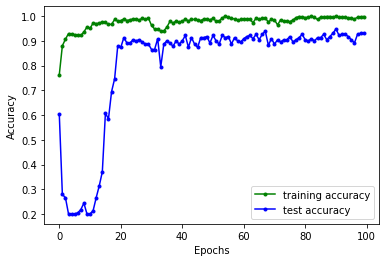

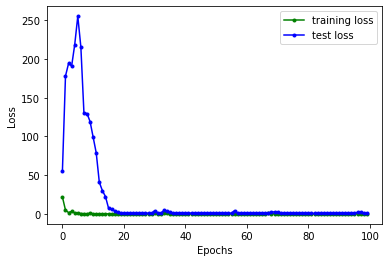

In [ ]:
with tf.device('/GPU:0'):
  model16 = ResNet('relu', model_number=1)
  model16.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model16.evaluate(X_test, y_test)
  model16.outputResult()
  model16.showPlots()
  model16.model.summary()
  plot_model(model16.model, show_shapes=True, to_file='Resnet1.png')

Epoch 1/100
60/60 - 31s - loss: 21.8767 - accuracy: 0.7714 - val_loss: 198.7255 - val_accuracy: 0.2140 - 31s/epoch - 516ms/step
Epoch 2/100
60/60 - 9s - loss: 8.0108 - accuracy: 0.8706 - val_loss: 462.8424 - val_accuracy: 0.2009 - 9s/epoch - 149ms/step
Epoch 3/100
60/60 - 9s - loss: 5.2788 - accuracy: 0.9024 - val_loss: 420.8663 - val_accuracy: 0.2009 - 9s/epoch - 150ms/step
Epoch 4/100
60/60 - 9s - loss: 2.6038 - accuracy: 0.9181 - val_loss: 315.1502 - val_accuracy: 0.2009 - 9s/epoch - 151ms/step
Epoch 5/100
60/60 - 12s - loss: 2.9059 - accuracy: 0.9290 - val_loss: 228.8180 - val_accuracy: 0.3013 - 12s/epoch - 195ms/step
Epoch 6/100
60/60 - 12s - loss: 0.8337 - accuracy: 0.9410 - val_loss: 172.1096 - val_accuracy: 0.3624 - 12s/epoch - 200ms/step
Epoch 7/100
60/60 - 12s - loss: 1.1496 - accuracy: 0.9562 - val_loss: 38.8048 - val_accuracy: 0.4891 - 12s/epoch - 198ms/step
Epoch 8/100
60/60 - 12s - loss: 2.0018 - accuracy: 0.9374 - val_loss: 35.2623 - val_accuracy: 0.5677 - 12s/epoch - 20

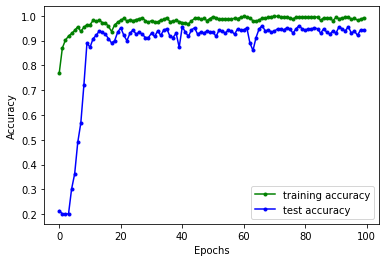

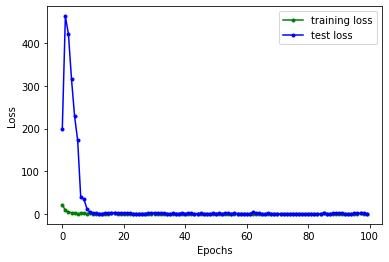

Model: "Inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 71, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 69, 94, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 69, 94, 64)  256         ['max_pooling2d[0][0]'

In [ ]:
with tf.device('/GPU:0'):
  model16a = ResNet('relu', model_number=1)
  model16a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model16a.evaluate(X_test, y_test)
  model16a.outputResult()
  model16a.showPlots()
  model16a.model.summary()
  plot_model(model16a.model, show_shapes=True, to_file='Resnet1.png')

## **Model 2**

Epoch 1/100
29/29 - 19s - loss: 1.3091 - accuracy: 0.7205 - val_loss: 1.2458 - val_accuracy: 0.6070 - 19s/epoch - 668ms/step
Epoch 2/100
29/29 - 11s - loss: 0.4403 - accuracy: 0.8483 - val_loss: 4.7842 - val_accuracy: 0.3100 - 11s/epoch - 375ms/step
Epoch 3/100
29/29 - 11s - loss: 0.3167 - accuracy: 0.9181 - val_loss: 5.3070 - val_accuracy: 0.2052 - 11s/epoch - 375ms/step
Epoch 4/100
29/29 - 11s - loss: 0.2094 - accuracy: 0.9279 - val_loss: 8.3014 - val_accuracy: 0.2271 - 11s/epoch - 375ms/step
Epoch 5/100
29/29 - 11s - loss: 0.2243 - accuracy: 0.9301 - val_loss: 11.2430 - val_accuracy: 0.2009 - 11s/epoch - 375ms/step
Epoch 6/100
29/29 - 11s - loss: 0.1301 - accuracy: 0.9520 - val_loss: 11.8189 - val_accuracy: 0.2183 - 11s/epoch - 375ms/step
Epoch 7/100
29/29 - 11s - loss: 0.1167 - accuracy: 0.9640 - val_loss: 11.8150 - val_accuracy: 0.2227 - 11s/epoch - 375ms/step
Epoch 8/100
29/29 - 11s - loss: 0.0953 - accuracy: 0.9749 - val_loss: 8.1439 - val_accuracy: 0.2576 - 11s/epoch - 375ms/st

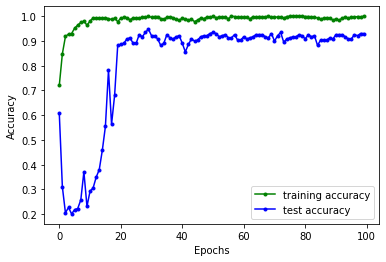

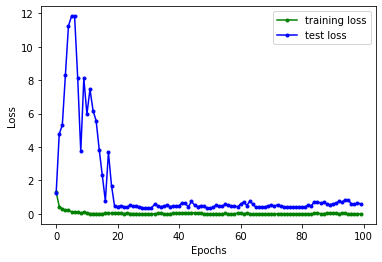

In [ ]:
with tf.device('/GPU:0'):
  model17 = ResNet('relu', model_number=2)
  model17.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model17.evaluate(X_test, y_test)
  model17.outputResult()
  model17.showPlots()

Epoch 1/100
60/60 - 10s - loss: 1.5291 - accuracy: 0.7281 - val_loss: 5.9357 - val_accuracy: 0.2009 - 10s/epoch - 168ms/step
Epoch 2/100
60/60 - 8s - loss: 0.5286 - accuracy: 0.8596 - val_loss: 12.6848 - val_accuracy: 0.2009 - 8s/epoch - 139ms/step
Epoch 3/100
60/60 - 8s - loss: 0.2913 - accuracy: 0.9102 - val_loss: 21.4515 - val_accuracy: 0.2009 - 8s/epoch - 141ms/step
Epoch 4/100
60/60 - 9s - loss: 0.1871 - accuracy: 0.9374 - val_loss: 17.7480 - val_accuracy: 0.2009 - 9s/epoch - 143ms/step
Epoch 5/100
60/60 - 8s - loss: 0.1177 - accuracy: 0.9588 - val_loss: 18.2235 - val_accuracy: 0.2009 - 8s/epoch - 141ms/step
Epoch 6/100
60/60 - 9s - loss: 0.1311 - accuracy: 0.9671 - val_loss: 11.1574 - val_accuracy: 0.2358 - 9s/epoch - 143ms/step
Epoch 7/100
60/60 - 9s - loss: 0.0588 - accuracy: 0.9791 - val_loss: 7.7670 - val_accuracy: 0.3406 - 9s/epoch - 142ms/step
Epoch 8/100
60/60 - 8s - loss: 0.1013 - accuracy: 0.9671 - val_loss: 3.7679 - val_accuracy: 0.4541 - 8s/epoch - 141ms/step
Epoch 9/1

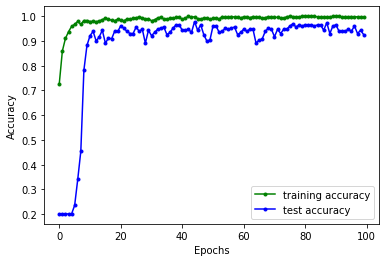

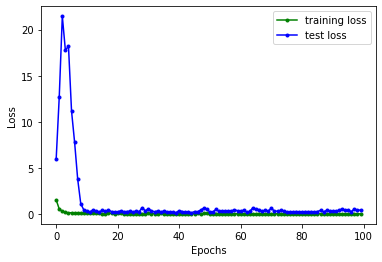

In [ ]:
with tf.device('/GPU:0'):
  model17a = ResNet('relu', model_number=2)
  model17a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model17a.evaluate(X_test, y_test)
  model17a.outputResult()
  model17a.showPlots()

## **Model 3**

Epoch 1/100
29/29 - 5s - loss: 2.5006 - accuracy: 0.6856 - val_loss: 1.3585 - val_accuracy: 0.5066 - 5s/epoch - 180ms/step
Epoch 2/100
29/29 - 2s - loss: 0.9503 - accuracy: 0.7707 - val_loss: 2.2811 - val_accuracy: 0.4803 - 2s/epoch - 66ms/step
Epoch 3/100
29/29 - 2s - loss: 0.5257 - accuracy: 0.8362 - val_loss: 2.6937 - val_accuracy: 0.3581 - 2s/epoch - 66ms/step
Epoch 4/100
29/29 - 2s - loss: 0.3472 - accuracy: 0.8570 - val_loss: 5.2136 - val_accuracy: 0.2140 - 2s/epoch - 66ms/step
Epoch 5/100
29/29 - 2s - loss: 0.3272 - accuracy: 0.8930 - val_loss: 3.9383 - val_accuracy: 0.2183 - 2s/epoch - 66ms/step
Epoch 6/100
29/29 - 2s - loss: 0.2757 - accuracy: 0.9116 - val_loss: 4.8427 - val_accuracy: 0.2271 - 2s/epoch - 66ms/step
Epoch 7/100
29/29 - 2s - loss: 0.3408 - accuracy: 0.9170 - val_loss: 4.3152 - val_accuracy: 0.2969 - 2s/epoch - 66ms/step
Epoch 8/100
29/29 - 2s - loss: 0.2144 - accuracy: 0.9279 - val_loss: 4.6428 - val_accuracy: 0.2314 - 2s/epoch - 66ms/step
Epoch 9/100
29/29 - 2s 

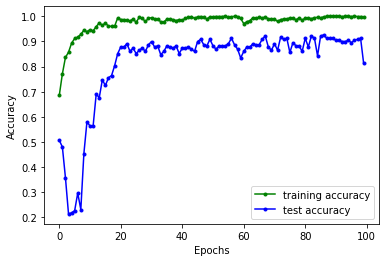

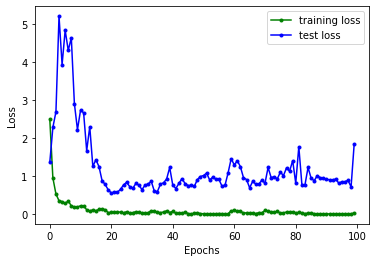

In [ ]:
with tf.device('/GPU:0'):
  model18 = ResNet('relu', model_number=3)
  model18.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model18.evaluate(X_test, y_test)
  model18.outputResult()
  model18.showPlots()

Epoch 1/100
60/60 - 25s - loss: 2.2756 - accuracy: 0.6858 - val_loss: 4.9159 - val_accuracy: 0.2358 - 25s/epoch - 420ms/step
Epoch 2/100
60/60 - 10s - loss: 0.9992 - accuracy: 0.8121 - val_loss: 8.7963 - val_accuracy: 0.2358 - 10s/epoch - 174ms/step
Epoch 3/100
60/60 - 10s - loss: 0.5323 - accuracy: 0.8586 - val_loss: 4.4748 - val_accuracy: 0.3406 - 10s/epoch - 175ms/step
Epoch 4/100
60/60 - 10s - loss: 0.3290 - accuracy: 0.9061 - val_loss: 9.6328 - val_accuracy: 0.2009 - 10s/epoch - 172ms/step
Epoch 5/100
60/60 - 10s - loss: 0.3252 - accuracy: 0.9128 - val_loss: 5.8416 - val_accuracy: 0.3144 - 10s/epoch - 171ms/step
Epoch 6/100
60/60 - 10s - loss: 0.2271 - accuracy: 0.9332 - val_loss: 2.1854 - val_accuracy: 0.5546 - 10s/epoch - 175ms/step
Epoch 7/100
60/60 - 10s - loss: 0.2069 - accuracy: 0.9457 - val_loss: 3.0467 - val_accuracy: 0.5371 - 10s/epoch - 171ms/step
Epoch 8/100
60/60 - 10s - loss: 0.1766 - accuracy: 0.9598 - val_loss: 1.7491 - val_accuracy: 0.6550 - 10s/epoch - 175ms/step


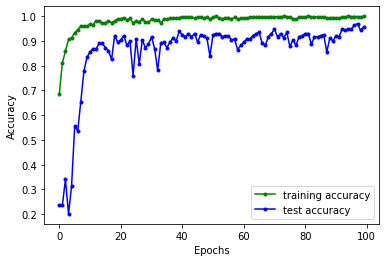

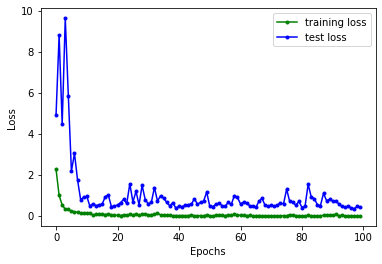

In [ ]:
with tf.device('/GPU:0'):
  model18a = ResNet('relu', model_number=3)
  model18a.train(X_train, y_train, (X_test, y_test), Adamax(0.001), 100)
  model18a.evaluate(X_test, y_test)
  model18a.outputResult()
  model18a.showPlots()

# **K Fold Cross Validation on Top 3 Models**

## **Implementation**

In [ ]:
def kfoldOnModel(model, inputs, targets, k=5):
  kfold = KFold(n_splits=k, shuffle=True)

  fold_no = 1
  for train, test in kfold.split(inputs, targets):
    copiedModel = deepcopy(model).model

    copiedModel.compile(loss=CategoricalCrossentropy(), optimizer='Adamax', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = copiedModel.fit(inputs[train], targets[train],
                        batch_size=64,
                        epochs=100,
                        verbose=0)

    # predict y_hat for test set
    y_hat_test = copiedModel.predict(inputs[test])
    y_hat_test = argmaxKeepDimensions(y_hat_test) #convert probablities to 0s and 1s

    # Generate generalization metrics and cofusion matrix
    evaluation_result = copiedModel.evaluate(inputs[test], targets[test], verbose=0)

    print(f'Result for fold {fold_no}: Loss= {evaluation_result[0]}  Acc= {evaluation_result[1]*100}% \n')
    print("confusion matrix: \n", metrics.confusion_matrix(np.argmax(targets[test], axis=1), np.argmax(y_hat_test, axis=1)))
    print(metrics.classification_report(targets[test], y_hat_test, digits=3, target_names=['Cloudy', 'Rain', 'Shine', 'Sunrise']))

    # Increase fold number
    fold_no = fold_no + 1

## **First Top Model**
RestNet

In [ ]:
with tf.device('/GPU:0'):
  top1Model = ResNet('relu', model_number=2)

  kfoldOnModel(top1Model, fixed_images, fixed_labels)

INFO:tensorflow:Assets written to: ram://3d8a27cb-921b-4c05-8390-0a87c0004d33/assets
------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.38019993901252747  Acc= 93.44978332519531% 

confusion matrix: 
 [[63  2  5  0]
 [ 2 42  0  0]
 [ 2  1 38  1]
 [ 0  0  2 71]]
              precision    recall  f1-score   support

      Cloudy      0.940     0.900     0.920        70
        Rain      0.933     0.955     0.944        44
       Shine      0.844     0.905     0.874        42
     Sunrise      0.986     0.973     0.979        73

   micro avg      0.934     0.934     0.934       229
   macro avg      0.926     0.933     0.929       229
weighted avg      0.936     0.934     0.935       229
 samples avg      0.934     0.934     0.934       229

INFO:tensorflow:Assets written to: ram://f0e43621-04db-4be0-a87c-29a4273aa35c/assets
------------------------------------------------------------------------
Training for fold 

## **Second Top Model**
CNN with pooling layer

In [ ]:
with tf.device('/GPU:0'):
  top2Model = CNN('relu', model_number=11)

  kfoldOnModel(top2Model, fixed_images, fixed_labels)

INFO:tensorflow:Assets written to: ram://9b712c27-87fd-4682-b7ab-ee493bc38408/assets
------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.23985642194747925  Acc= 92.00000166893005% 

confusion matrix: 
 [[61  0  4  0]
 [ 8 36  0  1]
 [ 2  0 43  0]
 [ 0  0  3 67]]
              precision    recall  f1-score   support

      Cloudy      0.859     0.938     0.897        65
        Rain      1.000     0.800     0.889        45
       Shine      0.860     0.956     0.905        45
     Sunrise      0.985     0.957     0.971        70

   micro avg      0.920     0.920     0.920       225
   macro avg      0.926     0.913     0.916       225
weighted avg      0.927     0.920     0.920       225
 samples avg      0.920     0.920     0.920       225

INFO:tensorflow:Assets written to: ram://ad95e057-eeef-46b3-bbcc-e827aec170df/assets
------------------------------------------------------------------------
Training for fold 

## **Third Top Model**
ResNet

In [ ]:
with tf.device('/GPU:0'):
  top3Model = ResNet('relu', model_number=3)

  kfoldOnModel(top3Model, fixed_images, fixed_labels)

INFO:tensorflow:Assets written to: ram://191496ce-bfc9-4e5e-a0e2-7df0f86b4aab/assets
------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.7681636810302734  Acc= 87.99999952316284% 

confusion matrix: 
 [[58  5  4  0]
 [ 8 27  1  1]
 [ 1  2 41  0]
 [ 2  0  3 72]]
              precision    recall  f1-score   support

      Cloudy      0.841     0.866     0.853        67
        Rain      0.794     0.730     0.761        37
       Shine      0.837     0.932     0.882        44
     Sunrise      0.986     0.935     0.960        77

   micro avg      0.880     0.880     0.880       225
   macro avg      0.864     0.866     0.864       225
weighted avg      0.882     0.880     0.880       225
 samples avg      0.880     0.880     0.880       225

INFO:tensorflow:Assets written to: ram://9dbb734d-0785-407a-b789-a36fc121cdfc/assets
------------------------------------------------------------------------
Training for fold 2

## **Fourth Top Model**
CNN with pooling

In [ ]:
with tf.device('/GPU:0'):
  top4Model = CNN('relu', model_number=7)

  kfoldOnModel(top4Model, fixed_images, fixed_labels)

INFO:tensorflow:Assets written to: ram://d4d58e41-014b-4caf-88d9-b2f1299bbc79/assets
------------------------------------------------------------------------
Training for fold 1 ...
Result for fold 1: Loss= 0.22248715162277222  Acc= 90.66666960716248% 

confusion matrix: 
 [[48  7  3  1]
 [ 1 35  0  0]
 [ 1  4 48  1]
 [ 2  0  1 73]]
              precision    recall  f1-score   support

      Cloudy      0.923     0.814     0.865        59
        Rain      0.761     0.972     0.854        36
       Shine      0.923     0.889     0.906        54
     Sunrise      0.973     0.961     0.967        76

   micro avg      0.907     0.907     0.907       225
   macro avg      0.895     0.909     0.898       225
weighted avg      0.914     0.907     0.907       225
 samples avg      0.907     0.907     0.907       225

INFO:tensorflow:Assets written to: ram://e91d4035-da40-4ea5-8765-9473077d552d/assets
------------------------------------------------------------------------
Training for fold 